Authors: José Raúl Romero (jrromero@uco.es), Aurora Ramírez (aurora.ramirez@uma.es), Francisco Javier Alcaide (f52almef@uco.es)

**Notebook for dummy model detection problem in the ECORE dataset**

- Algorithms used: SVC, RF and KNN

- The top 3 features with greatest contribution in each case have been considered for the calculation of the coincidence metrics between explainability techniques.

# Installation:

It is important to define the path to the folder that contains the Modelset files, in this notebook using the variable "MODELSET_HOME".

In [ ]:
MODELSET_HOME="/content/drive/MyDrive/modelset"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install modelset-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=5f628fa893df2cb893572629c4cde4b029e846fe10cb46c3fd4647f4d4b121cc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2


In [ ]:
!pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=18d55ebe3a37675fd6d99493d6bc7942a8efafb0db11046f929134aa1bcb82f2
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=41e353c7d8a6d4e889b9804652bb8d7177593f9b458a02d34cc9a7a7f1eaad6e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import sys
import re
import pickle
import plotly
import kaleido
import pandas as pd
import numpy as np
import dalex as dx
import os
import modelset.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.inspection import permutation_importance

## Functions:

In [ ]:
# Function to evaluate the sign of values
def evaluate_value(value):
    if value >= 0:
        return "Positive"
    else:
        return "Negative"

In [ ]:
# Create the MultiIndex columns
columns_multi = pd.MultiIndex.from_tuples([
    ('Breakdown', 'Ranking'), ('Breakdown', 'Sign'),
    ('Shap', 'Ranking'), ('Shap', 'Sign'),
    ('Lime', 'Ranking'), ('Lime', 'Sign')
])

In [ ]:
# Function to evaluate the top 3 Features
def top3_features(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = set(df[df[(tech, 'Ranking')].isin([1, 2, 3])].index)
        set_expl[tech] = inst_top3

    result_case = {
        f'TOP3 {tech}': ', '.join(set_expl[tech]) for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'
                result_case[col_name] = len(inst_top3_1.intersection(inst_top3_2)) / 3

    df_top3_case = pd.DataFrame(result_case, index=[case])

    return df_top3_case

In [ ]:
# Function to evaluate the top 3 ranking
def top3_rank(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = df[df[(tech, 'Ranking')].isin([1, 2, 3])]
        inst_top3_str = ', '.join([f'{ranking}:{inst}' for ranking, inst in zip(inst_top3[(tech, 'Ranking')], inst_top3.index)])

        set_expl[tech] = inst_top3_str

    result_case = {
        f'TOP3 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top3_1.split(', ') if inst in inst_top3_2.split(', ') and inst.split(':')[1] == inst.split(':')[1]]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 3

    df_top3_rank = pd.DataFrame(result_case, index=[case])

    return df_top3_rank

In [ ]:
# Function to evaluate the top 3 sign
def top3_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = df[df[(tech, 'Ranking')].isin([1, 2, 3])]
        inst_top3_str = ', '.join([f'{inst}:{sign}' for inst, sign in zip(inst_top3.index, inst_top3[(tech, 'Sign')])])

        set_expl[tech] = inst_top3_str

    result_case = {
        f'TOP3 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top3_1.split(', ') if inst in inst_top3_2.split(', ')]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 3

    df_top3_sign = pd.DataFrame(result_case, index=[case])

    return df_top3_sign

In [ ]:
# Function to evaluate the top 3 sign and ranking
def top3_rank_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = df[df[(tech, 'Ranking')].isin([1, 2, 3])]
        inst_top3_str = ', '.join([f'{ranking}:{inst}:{sign}' for ranking, inst, sign in zip(inst_top3[(tech, 'Ranking')], inst_top3.index, inst_top3[(tech, 'Sign')])])
        set_expl[tech] = inst_top3_str

    result_case = {
        f'TOP3 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top3_1.split(', ') if inst in inst_top3_2.split(', ') and inst.split(':')[1] == inst.split(':')[1] and inst.split(':')[2] == inst.split(':')[2]]
                num_coincidence = len(coincidence)
                result_case[col_name] = num_coincidence / 3

    df_top3_rank_sign = pd.DataFrame(result_case, index=[case])

    return df_top3_rank_sign

In [ ]:
# Function to obtain the dataframes of the tech Breakdown, SHAP, and LIME.
def preprocess_dfs(breakdown_df, shap_df, lime_df, n, m):

    pattern = re.compile(r'(?:<=|<|>=|>)\s*(\w+)\s*(?:<=|<|>=|>)')

    breakdown_df = breakdown_df.loc[:, ['variable_name', 'contribution', 'sign']]
    breakdown_df = breakdown_df.drop(index=[0, n+1])
    breakdown_df['sign'] = breakdown_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    breakdown_df = breakdown_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    shap_df = shap_df.loc[:, ['variable_name', 'contribution', 'sign']]
    shap_df = shap_df.tail(n)
    shap_df['sign'] = shap_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    shap_df = shap_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    lime_list = []
    for feature in lime_df['variable']:
      if pattern.findall(feature):
        match = pattern.search(feature)
        if match:
          lime_list.append(match.group(1))
      else:
        splits = feature.split(" ")
        lime_list.append(splits[0])

    lime_df["Feature"] = lime_list
    lime_df["Sign"] = lime_df["effect"].apply(evaluate_value)
    lime_df = lime_df.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
    lime_df = lime_df.drop(columns=['variable'])

    breakdown_df['Ranking'] = breakdown_df['contribution'].abs().rank(ascending=False).astype(int)
    breakdown_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    breakdown_df = breakdown_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    shap_df['Ranking'] = shap_df['contribution'].abs().rank(ascending=False).astype(int)
    shap_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    shap_df = shap_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    lime_df['Ranking'] = lime_df['effect'].abs().rank(ascending=False).astype(int)
    lime_df = lime_df.head(m)
    lime_df = lime_df[['Feature', 'Ranking', 'effect', 'Sign']]

    breakdown_df = breakdown_df.drop(columns=['contribution'])
    shap_df = shap_df.drop(columns=['contribution'])
    lime_df = lime_df.drop(columns=['effect'])

    breakdown_df = breakdown_df.head(m)
    breakdown_df = breakdown_df.reset_index(drop=True)

    shap_df= shap_df.head(m)
    shap_df = shap_df.reset_index(drop=True)

    lime_df = lime_df.reset_index(drop=True)

    breakdown_features = list(breakdown_df['Feature'])
    shap_features = list(shap_df['Feature'])
    lime_features = list(lime_df['Feature'])
    all_features = list(set(breakdown_features + shap_features + lime_features))
    all_features = all_features[::-1]

    df_final = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
    df_final['Feature'] = list(all_features)
    df_final = df_final[['Feature', 'Breakdown', 'Shap', 'Lime']]

    #print(breakdown_features)
    #print(shap_features)
    #print(lime_features)
    print(all_features)

    for feature in df_final['Feature']:

        breakdown_row = breakdown_df[breakdown_df['Feature'] == feature]
        if not breakdown_row.empty:

            ranking_breakdown = breakdown_row.iloc[0]['Ranking']
            sign_breakdown = breakdown_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = sign_breakdown
        else:

            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


        shap_row = shap_df[shap_df['Feature'] == feature]
        if not shap_row.empty:
            ranking_shap = shap_row.iloc[0]['Ranking']
            sign_shap = shap_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = sign_shap
        else:
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = '-'


        lime_row = lime_df[lime_df['Feature'] == feature]
        if not lime_row.empty:
            ranking_lime = lime_row.iloc[0]['Ranking']
            sign_lime = lime_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = sign_lime
        else:
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = '-'


    ranking_breakdown = df_final[('Breakdown', 'Ranking')]
    values_valid = ranking_breakdown[ranking_breakdown != '-']
    cases_invalid = ranking_breakdown[ranking_breakdown == '-'].index
    cases_valid = []
    cases_invalid_restantes = list(cases_invalid)
    cases_valid.extend(values_valid.sort_values().index.tolist())

    for cas in cases_invalid:
        value_shap = df_final.at[cas, ('Shap', 'Ranking')]
        if value_shap != '-':
            cases_valid.extend([cas])
            cases_invalid_restantes.remove(cas)

    for cas in cases_invalid_restantes:
        value_lime = df_final.at[cas, ('Lime', 'Ranking')]
        if value_lime != '-':
            cases_valid.extend([cas])

    df_final = df_final.loc[cases_valid]
    df_final.set_index('Feature', inplace=True)
    return breakdown_df, shap_df, lime_df, df_final


In [ ]:
# Function to create final dataframes with all the disagreement metrics and calculate the means of disagreement metrics for each pair of techniques.
def calculate_metrics(df_list):
    df_final = pd.concat(df_list)

    mean_bd_shap = df_final['Breakdown-Shap'].mean()
    mean_bd_lime = df_final['Breakdown-Lime'].mean()
    mean_lime_shap = df_final['Lime-Shap'].mean()

    return df_final, mean_bd_shap, mean_bd_lime, mean_lime_shap

In [ ]:
# Function to create dictionaries containing the disagreement metrics dataframes
def create_metrics_dfs(metrics_dict, metric_type):
    dfs = {'Model_comparison': {}, 'Class_comparison': {}}
    columns_model = ['Class', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    columns_class = ['Model', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    metric_names = [f'Mean_{metric_type}_BD_Shap', f'Mean_{metric_type}_BD_Lime', f'Mean_{metric_type}_Lime_Shap']

    for model_name, indexes_dict in metrics_dict.items():
        for index_name, metrics in indexes_dict.items():
            if model_name not in dfs['Class_comparison']:
                dfs['Class_comparison'][model_name] = pd.DataFrame(columns=columns_model)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            class_data = [index_name] + get_metrics
            dfs['Class_comparison'][model_name] = pd.concat([dfs['Class_comparison'][model_name], pd.Series(class_data, index=columns_model).to_frame().T], ignore_index=True)

            if index_name not in dfs['Model_comparison']:
                dfs['Model_comparison'][index_name] = pd.DataFrame(columns=columns_class)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            model_data = [model_name] + get_metrics
            dfs['Model_comparison'][index_name] = pd.concat([dfs['Model_comparison'][index_name], pd.Series(model_data, index=columns_class).to_frame().T], ignore_index=True)

    return dfs

In [ ]:
# Function to obtain dataframes of explanations, disagreement metrics, and each of the disagreement metrics dataframes
def calculate_metrics_for_indices(models_dict, indexes_dict, X_test, X_train, y_train, num_features, top_num_features):
    results_dict = {}
    metrics_dict = {}

    for model_name, model in models_dict.items():
        results_dict[model_name] = {}
        metrics_dict[model_name] = {}

        exp = dx.Explainer(model, X_train, y_train)

        for index_name, indices in indexes_dict.items():
          results_dict[model_name][index_name] = {}
          metrics_dict[model_name][index_name] = {}
          model_results = results_dict[model_name][index_name]
          df_list_top = []
          df_list_rank = []
          df_list_sign = []
          df_list_rank_sign = []

          for i in indices:
            instance = X_test.loc[i]

            breakdown = exp.predict_parts(instance, type="break_down", random_state=42)
            shap = exp.predict_parts(instance, type="shap", random_state=42)
            lime = exp.predict_surrogate(instance, random_state=42)
            breakdown_df = breakdown.result
            shap_df = shap.result
            lime_df = lime.result

            breakdown_df, shap_df, lime_df, df_final = preprocess_dfs(breakdown_df, shap_df, lime_df, num_features, top_num_features)

            model_results[f"breakdown_df_{i}"] = breakdown_df
            model_results[f"shap_df_{i}"] = shap_df
            model_results[f"lime_df_{i}"] = lime_df
            model_results[f"df_final_{i}"] = df_final

            metrics_dict[model_name][index_name][f"df_top_metric_{i}"] = top3_features(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            metrics_dict[model_name][index_name][f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            #model_results[f"df_top_metric_{i}"] = top3_features(df_final, i)
            #model_results[f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            #model_results[f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            #model_results[f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            df_list_top.append(metrics_dict[model_name][index_name][f'df_top_metric_{i}'])
            df_list_rank.append(metrics_dict[model_name][index_name][f'df_rank_metric_{i}'])
            df_list_sign.append(metrics_dict[model_name][index_name][f'df_sign_metric_{i}'])
            df_list_rank_sign.append(metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'])

          df_top_metric_final, mean_top_bd_shap, mean_top_bd_lime, mean_top_lime_shap = calculate_metrics(df_list_top)
          df_rank_metric_final, mean_rank_bd_shap, mean_rank_bd_lime, mean_rank_lime_shap = calculate_metrics(df_list_rank)
          df_sign_metric_final, mean_sign_bd_shap, mean_sign_bd_lime, mean_sign_lime_shap = calculate_metrics(df_list_sign)
          df_rank_sign_metric_final, mean_rank_sign_bd_shap, mean_rank_sign_bd_lime, mean_rank_sign_lime_shap = calculate_metrics(df_list_rank_sign)

          metrics_dict[model_name][index_name][f'Mean_top_BD_Shap'] = mean_top_bd_shap
          metrics_dict[model_name][index_name][f'Mean_top_BD_Lime'] = mean_top_bd_lime
          metrics_dict[model_name][index_name][f'Mean_top_Lime_Shap'] = mean_top_lime_shap
          metrics_dict[model_name][index_name][f'df_top_metric_final'] = df_top_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_BD_Shap'] = mean_rank_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_BD_Lime'] = mean_rank_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_Lime_Shap'] = mean_rank_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_metric_final'] = df_rank_metric_final

          metrics_dict[model_name][index_name][f'Mean_sign_BD_Shap'] = mean_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_sign_BD_Lime'] = mean_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_sign_Lime_Shap'] = mean_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_sign_metric_final'] = df_sign_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Shap'] = mean_rank_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Lime'] = mean_rank_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_sign_Lime_Shap'] = mean_rank_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_sign_metric_final'] = df_rank_sign_metric_final

    top_metric_df = create_metrics_dfs(metrics_dict, 'top')
    rank_metric_df = create_metrics_dfs(metrics_dict, 'rank')
    sign_metric_df = create_metrics_dfs(metrics_dict, 'sign')
    rank_sign_metric_df = create_metrics_dfs(metrics_dict, 'rank_sign')

    return metrics_dict, results_dict, top_metric_df, rank_metric_df, sign_metric_df, rank_sign_metric_df


# Load and Preprocess:

In this section, we will perform data loading, cleaning, preprocessing, and an initial data analysis.

In [ ]:
dataset = ds.load(MODELSET_HOME,modeltype = 'ecore', selected_analysis = ['stats']) # load the dataset
modelset_df = dataset._Dataset__to_df()

In [ ]:
duplicates = modelset_df.duplicated(subset='id', keep=False)
inst_dup = modelset_df[duplicates]
inst_dup

,id,category,tags,language,references,elements,classes,attributes,packages,enum,datatypes


In [ ]:
modelset_df

,id,category,tags,language,references,elements,classes,attributes,packages,enum,datatypes
0,repo-ecore-all/data/mde-optimiser/comma-18-map...,arguments,NaN,english,12,42,5,6,1,0,0
2,repo-ecore-all/data/AmerPecuj/MBSE/dk.dtu.comp...,petrinet,behaviour,english,7,27,6,2,1,0,0
3,repo-ecore-all/data/nlohmann/service-technolog...,petrinet,behaviour,english,13,92,15,16,1,2,0
4,repo-ecore-all/data/damenac/puzzle/examples/em...,education,domainmodel,english,4,37,4,12,1,0,0
5,repo-ecore-all/data/ModelWriter/AlloyInEcore/S...,dummy,NaN,english,0,71,6,19,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
5470,repo-ecore-all/data/BlackBeltTechnology/emfbui...,company,NaN,english,2,22,5,4,2,0,0
5471,repo-ecore-all/data/fmdkdd/monoge/emftuto/test...,dummy,NaN,english,3,9,2,0,1,0,0
5472,repo-ecore-all/data/gssi/Edelta_bad_smells/mod...,dummy,NaN,english,3,17,6,1,1,0,0
5473,repo-ecore-all/data/mathiasnh/TDT4250-Assignme...,education,university|domainmodel,english,24,101,11,12,1,2,0


In [ ]:
modelset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5466 entries, 0 to 5474
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5466 non-null   object
 1   category    5466 non-null   object
 2   tags        3824 non-null   object
 3   language    5466 non-null   object
 4   references  5466 non-null   int64 
 5   elements    5466 non-null   int64 
 6   classes     5466 non-null   int64 
 7   attributes  5466 non-null   int64 
 8   packages    5466 non-null   int64 
 9   enum        5466 non-null   int64 
 10  datatypes   5466 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 512.4+ KB


In [ ]:
# Reset index
modelset_df = modelset_df.reset_index(drop=True)

# Delete columns that are not useful
modelset_df = modelset_df.drop(['elements'], axis=1)
modelset_df = modelset_df.drop(['tags'], axis=1)
modelset_df = modelset_df.drop(['language'], axis=1)
modelset_df = modelset_df.drop(['id'], axis=1)

modelset_df_dummy = modelset_df.copy()

col = modelset_df.columns
col = col.drop('category')
col

Index(['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes'], dtype='object')

In [ ]:
#modelset_df_original.to_csv('ModelSet_ecore.csv')

In [ ]:
modelset_df.head()

,category,references,classes,attributes,packages,enum,datatypes
0,arguments,12,5,6,1,0,0
1,petrinet,7,6,2,1,0,0
2,petrinet,13,15,16,1,2,0
3,education,4,4,12,1,0,0
4,dummy,0,6,19,2,2,2


In [ ]:
modelset_df.describe()

,references,classes,attributes,packages,enum,datatypes
count,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000
mean,26.673253,25.739297,16.268203,1.459202,1.237834,1.236004
std,51.137585,43.285126,33.742160,2.378441,5.487452,5.356692
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,9.000000,8.000000,6.000000,1.000000,0.000000,0.000000
75%,25.000000,24.000000,16.000000,1.000000,1.000000,0.000000
max,1128.000000,391.000000,777.000000,46.000000,344.000000,58.000000


In [ ]:
modelset_df['category'].value_counts()

dummy                     729
statemachine              392
petrinet                  236
library                   235
modelling                 209
                         ... 
policies                    1
webservice                  1
decisiontree                1
addressbook-veterinary      1
aspects                     1
Name: category, Length: 222, dtype: int64

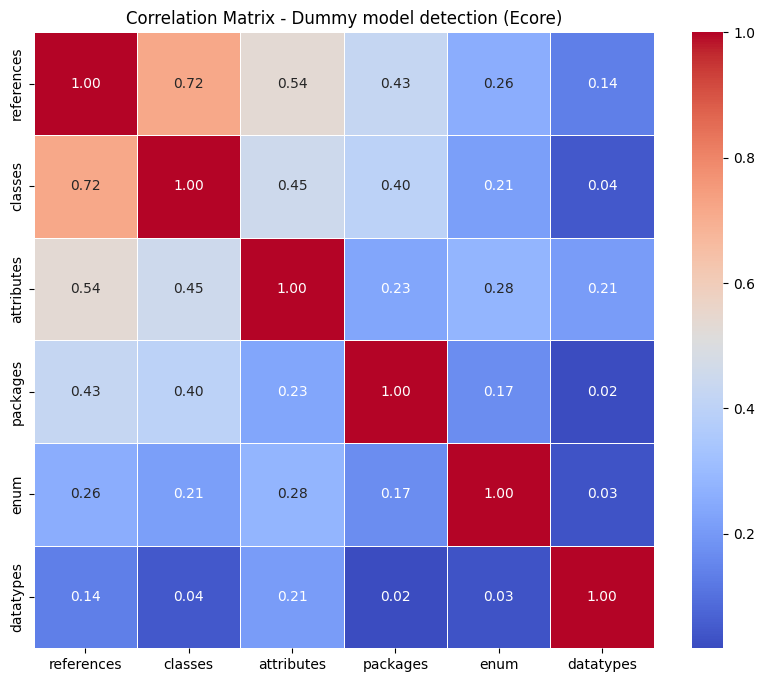

In [ ]:
# Correlation
correlation_matrix = modelset_df_dummy.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix - Dummy model detection (Ecore)')
plt.show()



---

❗❗ **No features with a correlation value greater than 0.8, so we are going to keep them all.**


---



In [ ]:
modelset_df_dummy['label'] = modelset_df_dummy['category'].apply(lambda x: 1 if x == 'dummy' else 0) # get the dummies
modelset_df_dummy = modelset_df_dummy.drop(['category'], axis=1)
modelset_df_dummy['label'].value_counts()

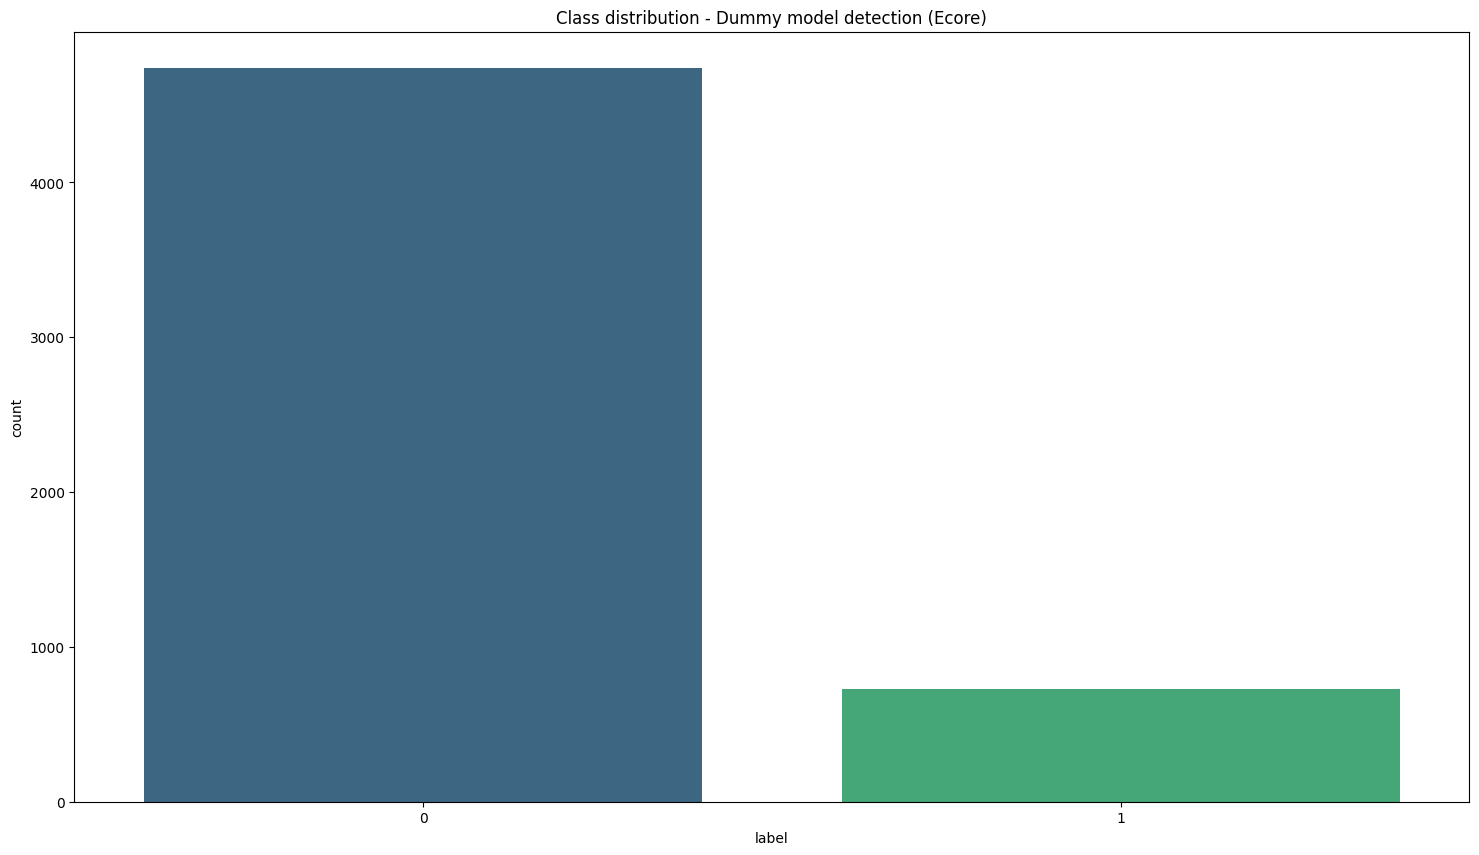

In [ ]:
# Class distribution
class_counts = modelset_df_dummy['label'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.countplot(x='label', data=modelset_df_dummy, order=class_counts.index, palette='viridis')
plt.title('Class distribution - Dummy model detection (Ecore)')
plt.show()



---

❗❗❗ **We verify that there is class imbalance**

---



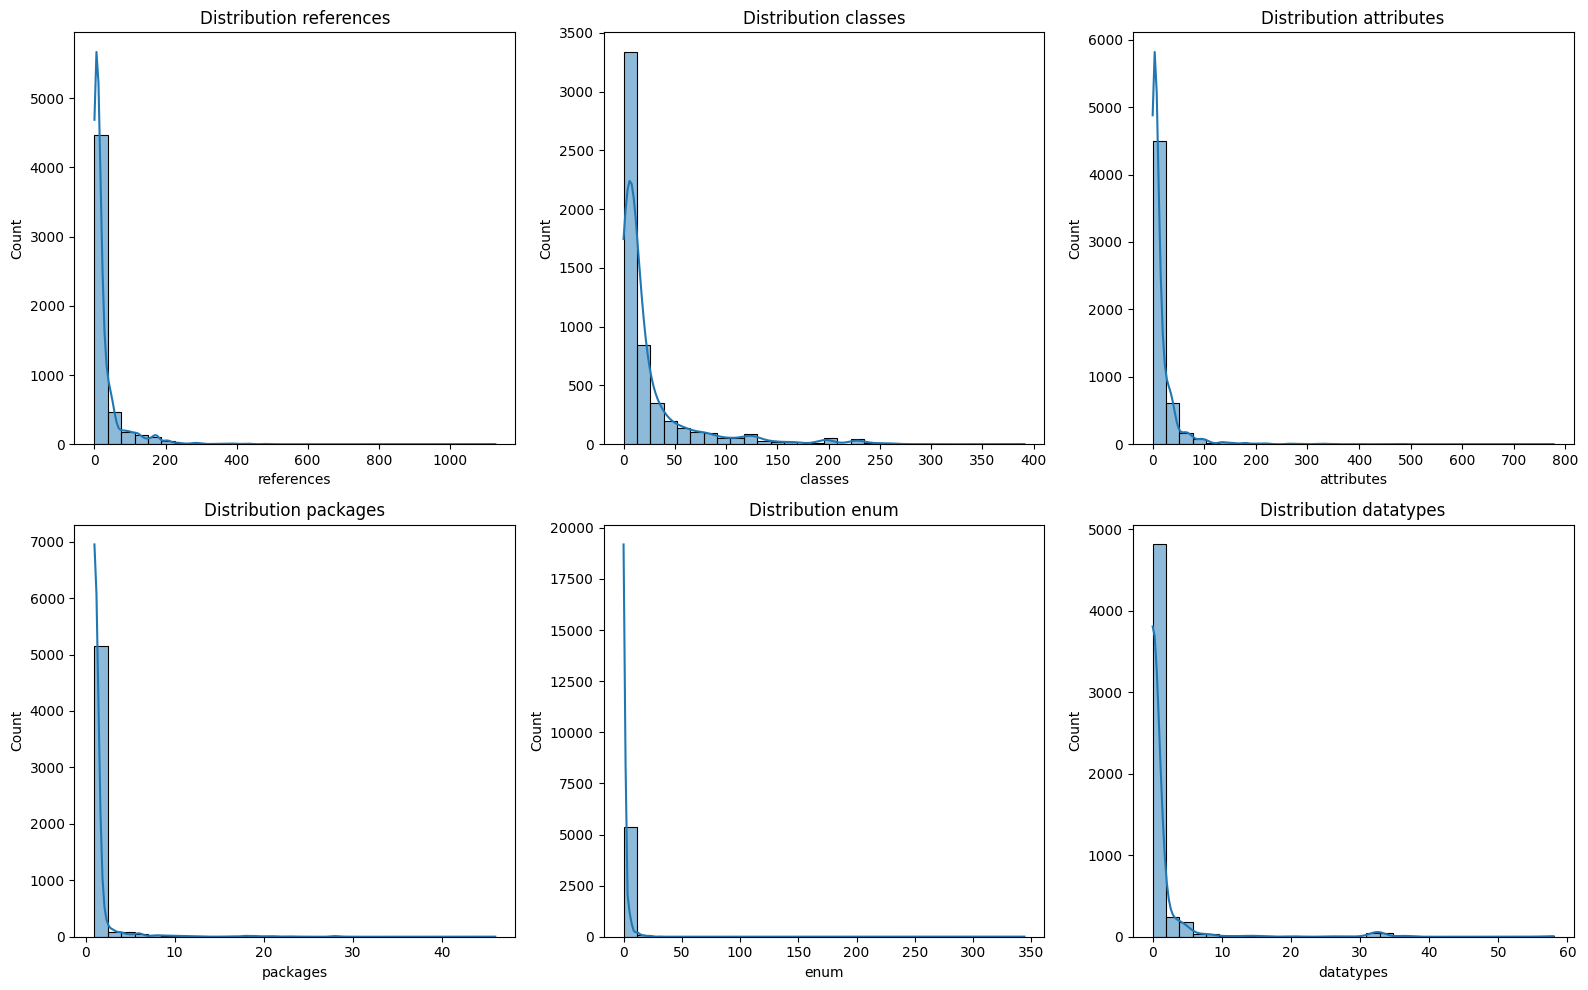

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(col):
    sns.histplot(modelset_df_dummy[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

# Models:

In this section, we perform the dataset splitting and data scaling. Afterward, we conduct a search for the best hyperparameters for our algorithms and define them with the best configuration found. Finally, we evaluate the performance.

In [ ]:
X = modelset_df_dummy[col]
Y = modelset_df_dummy['label']
X_train_split, X_test_split, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
X_train_split

,references,classes,attributes,packages,enum,datatypes
4038,13,13,11,1,0,0
1083,1,4,1,1,0,0
5052,48,20,33,1,0,33
5011,0,0,0,1,0,13
3965,7,4,5,1,0,0
...,...,...,...,...,...,...
2572,2,2,4,2,0,3
2217,3,1,1,1,0,0
2400,96,35,31,6,0,0
5399,12,11,26,1,2,0


In [ ]:
X_test_split

,references,classes,attributes,packages,enum,datatypes
355,0,32,1,1,0,0
4367,55,17,42,1,4,4
397,2,1,1,1,0,0
4070,4,3,5,1,1,0
2135,4,198,1,1,1,0
...,...,...,...,...,...,...
4405,5,4,2,1,0,0
5082,5,3,1,1,0,0
4035,4,7,5,1,0,0
3181,21,32,10,1,6,0


In [ ]:
X_train_index = X_train_split.index
X_test_index = X_test_split.index

scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train_split)
X_train = pd.DataFrame(X_train_scal, columns=X_train_split.columns, index=X_train_index)

X_test_scal = scaler.transform(X_test_split)
X_test = pd.DataFrame(X_test_scal, columns=X_test_split.columns, index=X_test_index)

In [ ]:
X_train

,references,classes,attributes,packages,enum,datatypes
4038,-0.265836,-0.285358,-0.141978,-0.191201,-0.395875,-0.231235
1083,-0.512558,-0.497436,-0.431644,-0.191201,-0.395875,-0.231235
5052,0.453769,-0.120408,0.495285,-0.191201,-0.395875,5.997762
5011,-0.533119,-0.591693,-0.460610,-0.191201,-0.395875,2.222612
3965,-0.389197,-0.497436,-0.315778,-0.191201,-0.395875,-0.231235
...,...,...,...,...,...,...
2572,-0.491998,-0.544565,-0.344744,0.242945,-0.395875,0.335037
2217,-0.471438,-0.568129,-0.431644,-0.191201,-0.395875,-0.231235
2400,1.440656,0.233056,0.437352,1.979530,-0.395875,-0.231235
5399,-0.286397,-0.332486,0.292520,-0.191201,0.301623,-0.231235


In [ ]:
X_test

,references,classes,attributes,packages,enum,datatypes
355,-0.533119,0.162363,-0.431644,-0.191201,-0.395875,-0.231235
4367,0.597690,-0.191101,0.755984,-0.191201,0.999121,0.523795
397,-0.491998,-0.568129,-0.431644,-0.191201,-0.395875,-0.231235
4070,-0.450878,-0.521000,-0.315778,-0.191201,-0.047126,-0.231235
2135,-0.450878,4.074030,-0.431644,-0.191201,-0.047126,-0.231235
...,...,...,...,...,...,...
4405,-0.430318,-0.497436,-0.402677,-0.191201,-0.395875,-0.231235
5082,-0.430318,-0.521000,-0.431644,-0.191201,-0.395875,-0.231235
4035,-0.450878,-0.426743,-0.315778,-0.191201,-0.395875,-0.231235
3181,-0.101355,0.162363,-0.170945,-0.191201,1.696619,-0.231235


In [ ]:
#X_train.to_csv('ecore_dummy_x_train.csv')
#y_train.to_csv('ecore_dummy_y_train.csv')
#X_test.to_csv('ecore_dummy_x_test.csv')
#y_test.to_csv('ecore_dummy_y_test.csv')

In [ ]:
score_result = pd.DataFrame(columns=['Model', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-score'])

## **SVC**:

In [ ]:
model = SVC(random_state=42, probability=True)
params={'C':[0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0],'kernel':['linear','rbf','sigmoid'],'gamma':['scale','auto', 0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0],'class_weight':[None, 'balanced']}
grid = GridSearchCV(model, params, cv=5, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
svc = SVC(C=300.0, gamma=500.0, probability=True, random_state=42)

In [ ]:
model_svc = svc.fit(X_train, y_train)

In [ ]:
y_pred_svc = model_svc.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_svc.squeeze()})
print(df_pred)

      Actual  Predicted
355        0          0
4367       0          0
397        0          0
4070       0          0
2135       0          0
...      ...        ...
4405       0          0
5082       0          0
4035       0          0
3181       0          0
3907       0          0

[1640 rows x 2 columns]


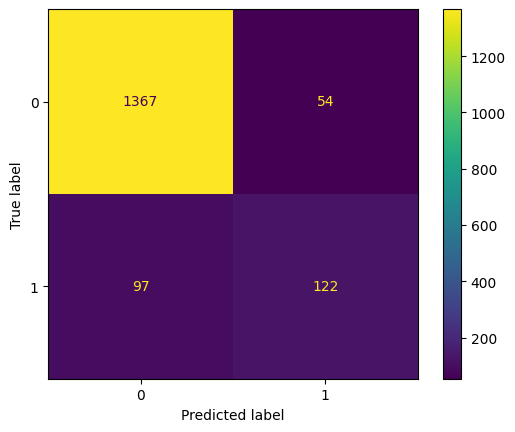

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_display_svc = ConfusionMatrixDisplay(cm_svc).plot()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7595381090556204
Recall: 0.5570776255707762
Precision: 0.6931818181818182
F1-score: 0.6177215189873417


In [ ]:
print("Accuracy test: ", model_svc.score(X_test, y_test))
print("Accuracy train: ", model_svc.score(X_train, y_train))

Accuracy test:  0.9079268292682927
Accuracy train:  0.9618400418191323


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(svc, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision', 'recall','f1'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision'], "\n Mean: ", np.mean(cv_results['test_precision']))
print("Recall:\n", cv_results['test_recall'], "\n Mean: ", np.mean(cv_results['test_recall']))
print("F1-score:\n", cv_results['test_f1'], "\n Mean: ", np.mean(cv_results['test_f1']))

Accuracy:
 [0.6875969  0.7296735  0.69478233 0.78665173 0.7175096 ] 
 Mean:  0.7232428113430406
Precision:
 [0.5        0.56097561 0.61290323 0.83870968 0.63636364] 
 Mean:  0.629790429869108
Recall:
 [0.44186047 0.52272727 0.43181818 0.59090909 0.47727273] 
 Mean:  0.4929175475687103
F1-score:
 [0.4691358  0.54117647 0.50666667 0.69333333 0.54545455] 
 Mean:  0.5511533637023833


In [ ]:
score_result= score_result.append({"Model":"SVC","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision']), "Recall":np.mean(cv_results['test_recall']), "F1-score":np.mean(cv_results['test_f1'])}, ignore_index=True)

## **RandomForest:**

In [ ]:
model = RandomForestClassifier(random_state=42)
params = {'n_estimators':[50, 100, 200, 300, 500],'min_samples_split':[2, 3, 5, 10],'min_samples_leaf':[1, 3, 5, 10],'max_depth':[1, 3, 5, 10, None], 'class_weight':['balanced', None]}
grid = GridSearchCV(model, params, cv=5, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 10, None],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='f1', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier(n_estimators=200, random_state=42)
0.6982673392137737


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
model_rf = rf.fit(X_train,y_train)

In [ ]:
y_pred_rf = model_rf.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_rf.squeeze()})
print(df_pred)

      Actual  Predicted
355        0          0
4367       0          0
397        0          0
4070       0          0
2135       0          0
...      ...        ...
4405       0          0
5082       0          0
4035       0          0
3181       0          0
3907       0          0

[1640 rows x 2 columns]


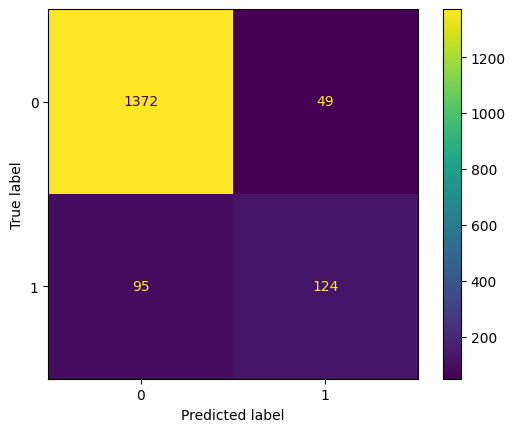

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(cm_rf).plot()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7658636435207054
Recall: 0.5662100456621004
Precision: 0.7167630057803468
F1-score: 0.6326530612244897


In [ ]:
print("Accuracy test: ", model_rf.score(X_test, y_test))
print("Accuracy train: ", model_rf.score(X_train, y_train))

Accuracy test:  0.9121951219512195
Accuracy train:  0.9626241505488761


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(rf, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision', 'recall','f1'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision'], "\n Mean: ", np.mean(cv_results['test_precision']))
print("Recall:\n", cv_results['test_recall'], "\n Mean: ", np.mean(cv_results['test_recall']))
print("F1-score:\n", cv_results['test_f1'], "\n Mean: ", np.mean(cv_results['test_f1']))

Accuracy:
 [0.73937169 0.7306338  0.71927017 0.743758   0.76472471] 
 Mean:  0.7395516737530634
Precision:
 [0.58974359 0.66666667 0.65625    0.6969697  0.69444444] 
 Mean:  0.6608148795648796
Recall:
 [0.53488372 0.5        0.47727273 0.52272727 0.56818182] 
 Mean:  0.5206131078224102
F1-score:
 [0.56097561 0.57142857 0.55263158 0.5974026  0.625     ] 
 Mean:  0.5814876715069269


In [ ]:
score_result= score_result.append({"Model":"RF","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision']), "Recall":np.mean(cv_results['test_recall']), "F1-score":np.mean(cv_results['test_f1'])}, ignore_index=True)

## **KNN:**

In [ ]:
model = KNeighborsClassifier()
params = {'n_neighbors':[2,3,4,5,7,10,20],'weights':['uniform','distance'],'leaf_size':[5,10,30,50,100],'p':[1,2,3]}
grid = GridSearchCV(model, params, cv=5, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 30, 50, 100],
                         'n_neighbors': [2, 3, 4, 5, 7, 10, 20], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=10, p=1, weights='distance')
0.6960612101814414


In [ ]:
knn = KNeighborsClassifier(leaf_size=100, p=1, weights='distance')

In [ ]:
model_knn = knn.fit(X_train,y_train)

In [ ]:
y_pred_knn = model_knn.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_knn.squeeze()})
print(df_pred)

      Actual  Predicted
355        0          0
4367       0          0
397        0          0
4070       0          0
2135       0          0
...      ...        ...
4405       0          0
5082       0          0
4035       0          0
3181       0          0
3907       0          0

[1640 rows x 2 columns]


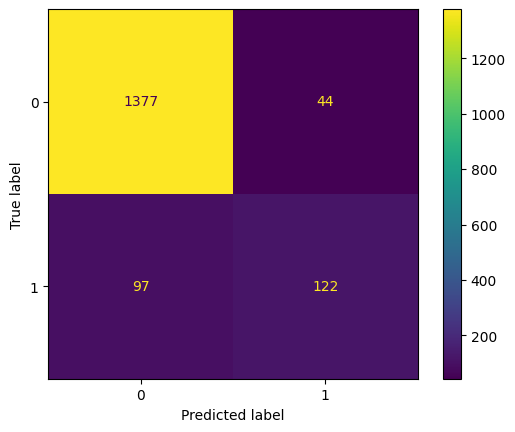

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(cm_knn).plot()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7630567578944663
Recall: 0.5570776255707762
Precision: 0.7349397590361446
F1-score: 0.6337662337662338


In [ ]:
print("Accuracy test: ", model_knn.score(X_test, y_test))
print("Accuracy train: ", model_knn.score(X_train, y_train))

Accuracy test:  0.9140243902439025
Accuracy train:  0.961578672242551


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(knn, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision', 'recall','f1'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision'], "\n Mean: ", np.mean(cv_results['test_precision']))
print("Recall:\n", cv_results['test_recall'], "\n Mean: ", np.mean(cv_results['test_recall']))
print("F1-score:\n", cv_results['test_f1'], "\n Mean: ", np.mean(cv_results['test_f1']))

Accuracy:
 [0.75099959 0.72711268 0.69830346 0.70966709 0.72103073] 
 Mean:  0.7214227096938667
Precision:
 [0.6        0.62857143 0.65517241 0.66666667 0.67741935] 
 Mean:  0.6455659727739816
Recall:
 [0.55813953 0.5        0.43181818 0.45454545 0.47727273] 
 Mean:  0.484355179704017
F1-score:
 [0.57831325 0.55696203 0.52054795 0.54054054 0.56      ] 
 Mean:  0.5512727528149047


In [ ]:
score_result= score_result.append({"Model":"KNN","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision']), "Recall":np.mean(cv_results['test_recall']), "F1-score":np.mean(cv_results['test_f1'])}, ignore_index=True)

## **Results:**

In [ ]:
score_result

,Model,Balanced Accuracy,Precision,Recall,F1-score
0,SVC,0.723243,0.629790,0.492918,0.551153
1,RF,0.739552,0.660815,0.520613,0.581488
2,KNN,0.721423,0.645566,0.484355,0.551273


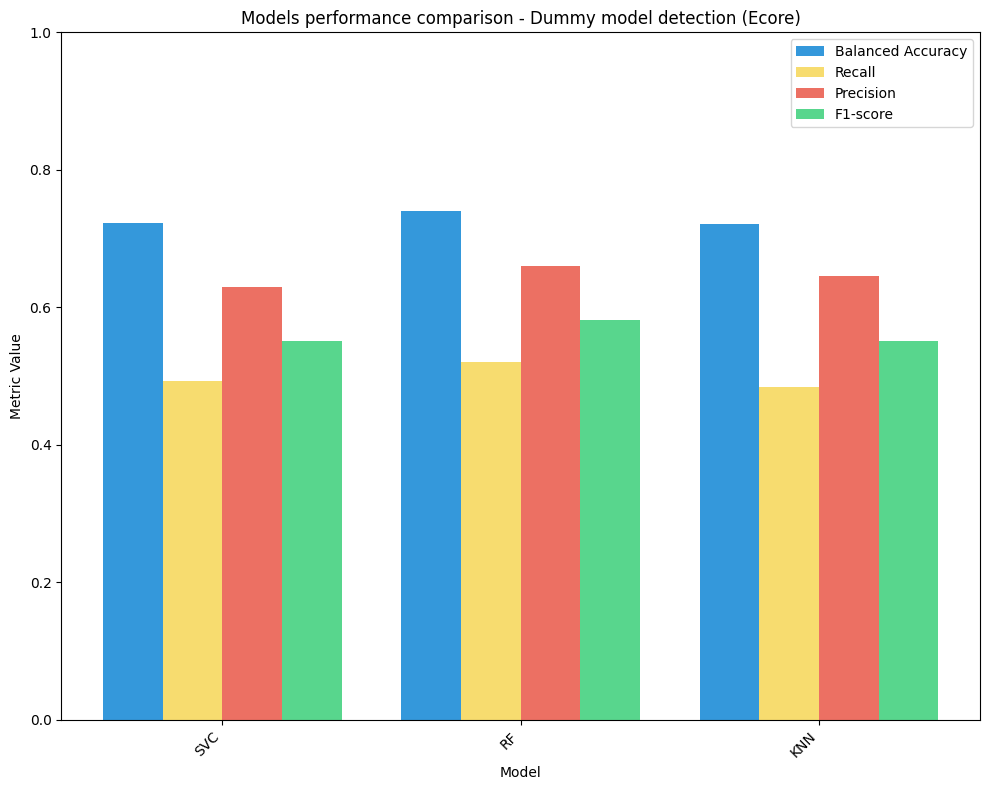

In [ ]:
# plot results
metrics = ['Balanced Accuracy', 'Recall', 'Precision', 'F1-score']
colors = ['#3498DB', '#F7DC6F','#EC7063', '#58D68D']

num_models = len(score_result)
width_bar = 0.20
x = range(num_models)

plt.figure(figsize=(10, 8))

for i, metric in enumerate(metrics):
    pos_x = [pos + i * width_bar for pos in x]

    values_metric = score_result[metric]
    plt.bar(
        pos_x,
        values_metric,
        width=width_bar,
        label=metric,
        color=colors[i],
    )

plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Models performance comparison - Dummy model detection (Ecore)')
plt.xticks([pos + (len(metrics) - 1) * width_bar / 2 for pos in x], score_result['Model'], rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0,1)
plt.show()

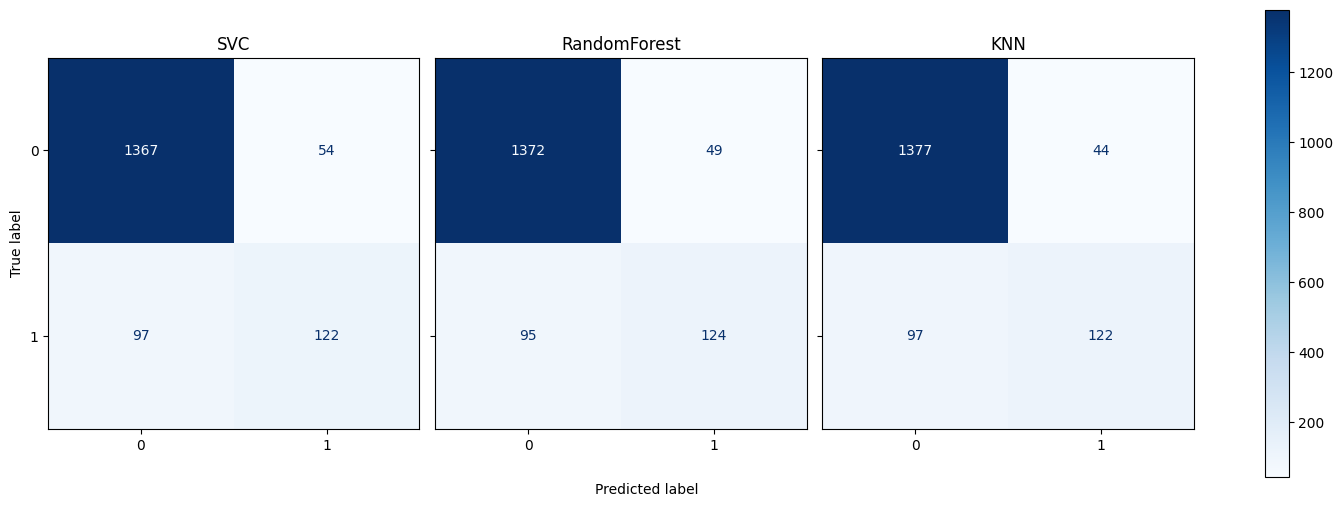

In [ ]:
classifiers = ["SVC", "RandomForest", "KNN"]
matrices_confusion = [cm_svc, cm_rf, cm_knn]
class_names = ["0", "1"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey="row")

for i, (cm, classifier_name) in enumerate(zip(matrices_confusion, classifiers)):

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(ax=axes[i], cmap="Blues")
    axes[i].set_title(classifier_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.tight_layout()
fig.text(0.4, 0.0, "Predicted label", ha="left")
fig.colorbar(disp.im_, ax=axes)
plt.show()

# Instance Selection:

In this section, we perform the selection of instances to be studied in local explainability. The selected instances must meet the condition of being classified in the same class by all three models.

In [ ]:
df_results = pd.DataFrame({'Real': y_test, 'Pred_KNN': y_pred_knn, 'Pred_SVC': y_pred_svc, 'Pred_RF': y_pred_rf})

prob_knn_0 = knn.predict_proba(X_test)[:, 0]
prob_svc_0 = svc.predict_proba(X_test)[:, 0]
prob_rf_0 = rf.predict_proba(X_test)[:, 0]
prob_knn_1 = knn.predict_proba(X_test)[:, 1]
prob_svc_1 = svc.predict_proba(X_test)[:, 1]
prob_rf_1 = rf.predict_proba(X_test)[:, 1]

df_results['Prob_KNN_0'] = prob_knn_0
df_results['Prob_KNN_1'] = prob_knn_1
df_results['Prob_SVC_0'] = prob_svc_0
df_results['Prob_SVC_1'] = prob_svc_1
df_results['Prob_RF_0'] = prob_rf_0
df_results['Prob_RF_1'] = prob_rf_1

df_preds = df_results[(df_results['Pred_KNN'] == df_results['Pred_SVC']) &
                             (df_results['Pred_SVC'] == df_results['Pred_RF'])]

df_tp = df_preds[(df_preds['Real'] == 1) &
                      (df_preds['Pred_KNN'] == 1) &
                      (df_preds['Pred_SVC'] == 1) &
                      (df_preds['Pred_RF'] == 1)]

df_tn = df_preds[(df_preds['Real'] == 0) &
                      (df_preds['Pred_KNN'] == 0) &
                      (df_preds['Pred_SVC'] == 0) &
                      (df_preds['Pred_RF'] == 0)]

df_fn = df_preds[(df_preds['Real'] == 1) &
                      (df_preds['Pred_KNN'] == 0) &
                      (df_preds['Pred_SVC'] == 0) &
                      (df_preds['Pred_RF'] == 0)]

df_fp = df_preds[(df_preds['Real'] == 0) &
                      (df_preds['Pred_KNN'] == 1) &
                      (df_preds['Pred_SVC'] == 1) &
                      (df_preds['Pred_RF'] == 1)]

In [ ]:
df_preds

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
355,0,0,0,0,1.0,0.0,0.922391,0.077609,1.000000,0.000000
4367,0,0,0,0,1.0,0.0,0.922395,0.077605,1.000000,0.000000
397,0,0,0,0,1.0,0.0,0.922388,0.077612,1.000000,0.000000
4070,0,0,0,0,1.0,0.0,0.922372,0.077628,1.000000,0.000000
2135,0,0,0,0,1.0,0.0,0.922342,0.077658,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
4405,0,0,0,0,1.0,0.0,0.939554,0.060446,1.000000,0.000000
5082,0,0,0,0,1.0,0.0,0.922371,0.077629,1.000000,0.000000
4035,0,0,0,0,1.0,0.0,0.985156,0.014844,0.974167,0.025833
3181,0,0,0,0,1.0,0.0,0.922417,0.077583,1.000000,0.000000


In [ ]:
df_tp

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
1813,1,1,1,1,0.200000,0.800000,0.394999,0.605001,0.246006,0.753994
1572,1,1,1,1,0.371613,0.628387,0.488341,0.511659,0.145000,0.855000
4290,1,1,1,1,0.000000,1.000000,0.394943,0.605057,0.213929,0.786071
4382,1,1,1,1,0.000000,1.000000,0.143748,0.856252,0.003984,0.996016
1274,1,1,1,1,0.000000,1.000000,0.394752,0.605248,0.010000,0.990000
...,...,...,...,...,...,...,...,...,...,...
2550,1,1,1,1,0.400000,0.600000,0.394772,0.605228,0.379460,0.620540
1478,1,1,1,1,0.000000,1.000000,0.394837,0.605163,0.045417,0.954583
427,1,1,1,1,0.000000,1.000000,0.395002,0.604998,0.000000,1.000000
5343,1,1,1,1,0.000000,1.000000,0.394872,0.605128,0.264582,0.735418


In [ ]:
df_tn

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
355,0,0,0,0,1.0,0.0,0.922391,0.077609,1.000000,0.000000
4367,0,0,0,0,1.0,0.0,0.922395,0.077605,1.000000,0.000000
397,0,0,0,0,1.0,0.0,0.922388,0.077612,1.000000,0.000000
4070,0,0,0,0,1.0,0.0,0.922372,0.077628,1.000000,0.000000
2135,0,0,0,0,1.0,0.0,0.922342,0.077658,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
4405,0,0,0,0,1.0,0.0,0.939554,0.060446,1.000000,0.000000
5082,0,0,0,0,1.0,0.0,0.922371,0.077629,1.000000,0.000000
4035,0,0,0,0,1.0,0.0,0.985156,0.014844,0.974167,0.025833
3181,0,0,0,0,1.0,0.0,0.922417,0.077583,1.000000,0.000000


In [ ]:
df_fp

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
664,0,1,1,1,0.000000,1.000000,0.395023,0.604977,0.192167,0.807833
3538,0,1,1,1,0.000000,1.000000,0.308028,0.691972,0.016992,0.983008
2734,0,1,1,1,0.000000,1.000000,0.100402,0.899598,0.177278,0.822722
3495,0,1,1,1,0.200000,0.800000,0.394999,0.605001,0.246006,0.753994
1180,0,1,1,1,0.000000,1.000000,0.395008,0.604992,0.300000,0.700000
808,0,1,1,1,0.400000,0.600000,0.394817,0.605183,0.304373,0.695627
1550,0,1,1,1,0.000000,1.000000,0.252062,0.747938,0.000000,1.000000
4327,0,1,1,1,0.400000,0.600000,0.394817,0.605183,0.304373,0.695627
4353,0,1,1,1,0.000000,1.000000,0.394970,0.605030,0.003000,0.997000
1882,0,1,1,1,0.000000,1.000000,0.394872,0.605128,0.264582,0.735418


In [ ]:
df_fn

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
330,1,0,0,0,1.0,0.0,0.914174,0.085826,0.985000,0.015000
624,1,0,0,0,0.6,0.4,0.922400,0.077600,0.729400,0.270600
3804,1,0,0,0,0.8,0.2,0.922355,0.077645,0.684000,0.316000
858,1,0,0,0,0.6,0.4,0.922400,0.077600,0.729400,0.270600
1520,1,0,0,0,0.5,0.5,0.755297,0.244703,0.520012,0.479988
...,...,...,...,...,...,...,...,...,...,...
1733,1,0,0,0,1.0,0.0,0.912532,0.087468,0.995000,0.005000
3615,1,0,0,0,0.8,0.2,0.875213,0.124787,0.691014,0.308986
2801,1,0,0,0,1.0,0.0,0.922428,0.077572,0.871765,0.128235
4731,1,0,0,0,0.8,0.2,0.922395,0.077605,0.657689,0.342311


In [ ]:
# Save instances indices
dfs_select = ["df_tp", "df_tn", "df_fp", "df_fn"]
inst_select_indexes = {}

for df_select in dfs_select:
    df = globals()[df_select]
    if len(df) > 100:
        indexes_inst = df.sample(n=100, random_state=42).index
    else:
        indexes_inst = df.index
    indexes_inst = list(indexes_inst)
    inst_select_indexes[df_select] = indexes_inst

In [ ]:
with open('ecore_dummy_indexes.pickle', 'wb') as f:
    pickle.dump(inst_select_indexes, f)

In [ ]:
index_max_prob_tp_knn = df_tp['Prob_KNN_1'].idxmax()
index_max_prob_tp_svc = df_tp['Prob_SVC_1'].idxmax()
index_max_prob_tp_rf = df_tp['Prob_RF_1'].idxmax()

index_max_prob_tn_knn = df_tn['Prob_KNN_0'].idxmax()
index_max_prob_tn_svc = df_tn['Prob_SVC_0'].idxmax()
index_max_prob_tn_rf = df_tn['Prob_RF_0'].idxmax()

index_max_prob_fp_knn = df_fp['Prob_KNN_1'].idxmax()
index_max_prob_fp_svc = df_fp['Prob_SVC_1'].idxmax()
index_max_prob_fp_rf = df_fp['Prob_RF_1'].idxmax()

index_max_prob_fn_knn = df_fn['Prob_KNN_0'].idxmax()
index_max_prob_fn_svc = df_fn['Prob_SVC_0'].idxmax()
index_max_prob_fn_rf = df_fn['Prob_RF_0'].idxmax()

In [ ]:
print("Instance with highest probability for TP - KNN: ", df_results.loc[index_max_prob_tp_knn].name)
print("Instance with highest probability for TP - SVC: ", df_results.loc[index_max_prob_tp_svc].name)
print("Instance with highest probability for TP - RF: ", df_results.loc[index_max_prob_tp_rf].name)
print("-----------------------------------------------------------")
print("Instance with highest probability for TN - KNN: ", df_results.loc[index_max_prob_tn_knn].name)
print("Instance with highest probability for TN - SVC: ", df_results.loc[index_max_prob_tn_svc].name)
print("Instance with highest probability for TN - RF: ", df_results.loc[index_max_prob_tn_rf].name)
print("-----------------------------------------------------------")
print("Instance with highest probability for FP - KNN: ", df_results.loc[index_max_prob_fp_knn].name)
print("Instance with highest probability for FP - SVC: ", df_results.loc[index_max_prob_fp_svc].name)
print("Instance with highest probability for FP - RF: ", df_results.loc[index_max_prob_fp_rf].name)
print("-----------------------------------------------------------")
print("Instance with highest probability for FN - KNN: ", df_results.loc[index_max_prob_fn_knn].name)
print("Instance with highest probability for FN - SVC: ", df_results.loc[index_max_prob_fn_svc].name)
print("Instance with highest probability for FN - RF: ", df_results.loc[index_max_prob_fn_rf].name)

Instance with highest probability for TP - KNN:  4290
Instance with highest probability for TP - SVC:  5215
Instance with highest probability for TP - RF:  4213
-----------------------------------------------------------
Instance with highest probability for TN - KNN:  355
Instance with highest probability for TN - SVC:  3395
Instance with highest probability for TN - RF:  355
-----------------------------------------------------------
Instance with highest probability for FP - KNN:  664
Instance with highest probability for FP - SVC:  3796
Instance with highest probability for FP - RF:  1550
-----------------------------------------------------------
Instance with highest probability for FN - KNN:  330
Instance with highest probability for FN - SVC:  2588
Instance with highest probability for FN - RF:  83


In [ ]:
inst_tp_knn = df_results.loc[index_max_prob_tp_knn].name
inst_tp_svc = df_results.loc[index_max_prob_tp_svc].name
inst_tp_rf = df_results.loc[index_max_prob_tp_rf].name

inst_tn_knn = df_results.loc[index_max_prob_tn_knn].name
inst_tn_svc = df_results.loc[index_max_prob_tn_svc].name
inst_tn_rf = df_results.loc[index_max_prob_tn_rf].name

inst_fp_knn = df_results.loc[index_max_prob_fp_knn].name
inst_fp_svc = df_results.loc[index_max_prob_fp_svc].name
inst_fp_rf = df_results.loc[index_max_prob_fp_rf].name

inst_fn_knn = df_results.loc[index_max_prob_fn_knn].name
inst_fn_svc = df_results.loc[index_max_prob_fn_svc].name
inst_fn_rf = df_results.loc[index_max_prob_fn_rf].name

# Explainability:

# Global Explainability:

We conduct the study of global explainability using permutation importance.

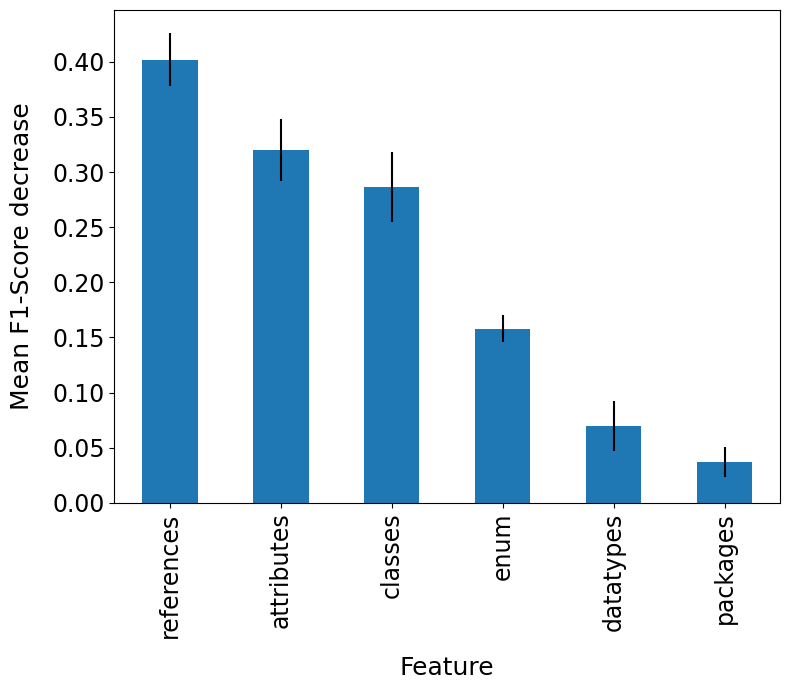

In [ ]:
permu = permutation_importance(model_svc, X_test, y_test, scoring='f1', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('ecore_dummy_globSVC.pdf')
plt.show()

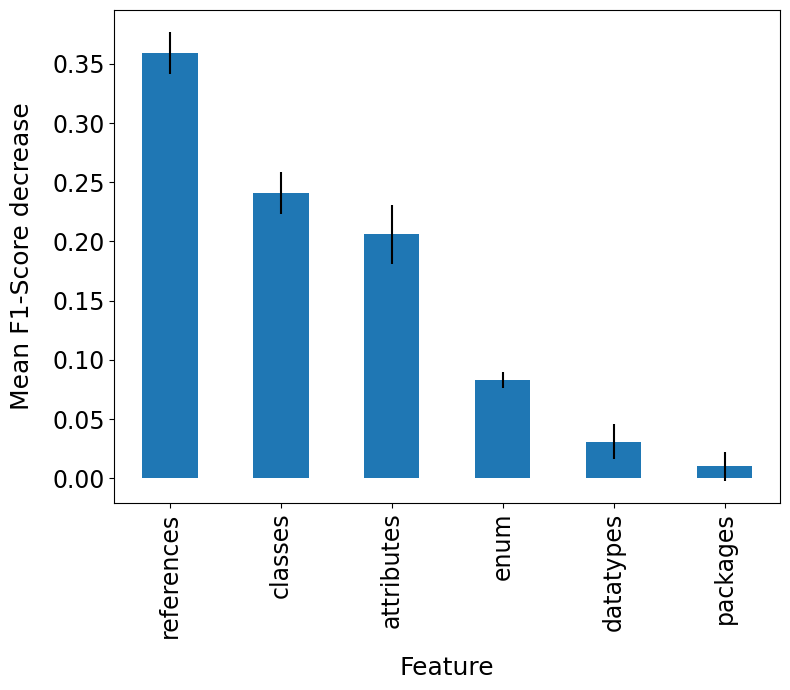

In [ ]:
permu = permutation_importance(model_rf, X_test, y_test, scoring='f1', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('ecore_dummy_globRF.pdf')
plt.show()

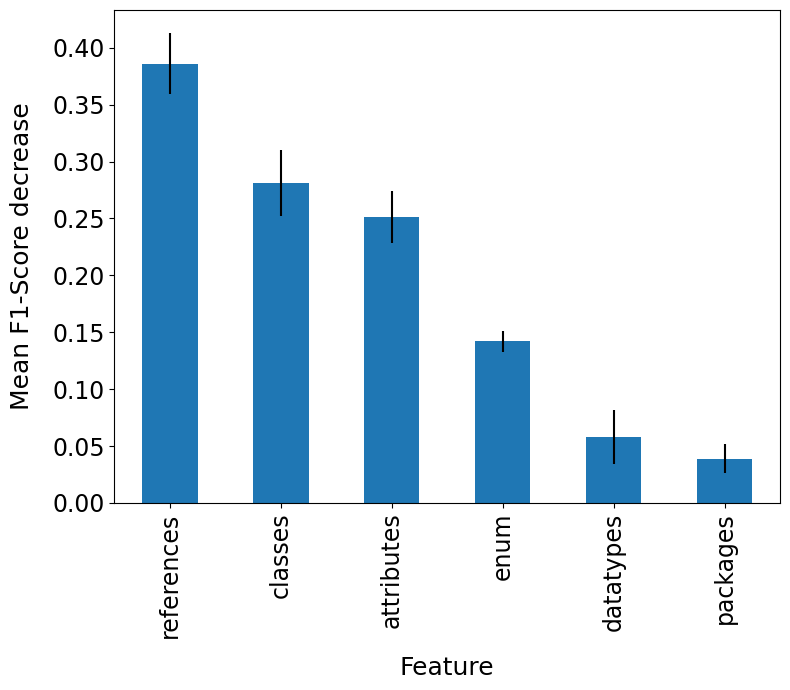

In [ ]:
permu = permutation_importance(model_knn, X_test, y_test, scoring='f1', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('ecore_dummy_globKNN.pdf')
plt.show()

# Local Explainability:

Finally, we obtain explanations for the selected instances and calculate the disagreement metrics.

In [ ]:
num_features = len(col)
top_num_features = 6

## SVC:

In [ ]:
exp = dx.Explainer(model_svc, X_train, y_train) # Initializing the explainer

Preparation of a new explainer is initiated

  -> data              : 3826 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3826 values
  -> model_class       : sklearn.svm._classes.SVC (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7e3daf51b760> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.32e-06, mean = 0.139, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.605, mean = -0.0058, max = 0.959
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
instance_tp = X_test.loc[inst_tp_svc]
instance_tn = X_test.loc[inst_tn_svc]
instance_fp = X_test.loc[inst_fp_svc]
instance_fn = X_test.loc[inst_fn_svc]

In [ ]:
breakdown_tp = exp.predict_parts(instance_tp, type="break_down",random_state=42)
shap_tp = exp.predict_parts(instance_tp, type="shap",random_state=42)
lime_tp = exp.predict_surrogate(instance_tp, random_state=42)

breakdown_tn = exp.predict_parts(instance_tn, type="break_down",random_state=42)
shap_tn = exp.predict_parts(instance_tn, type="shap",random_state=42)
lime_tn = exp.predict_surrogate(instance_tn, random_state=42)

breakdown_fp = exp.predict_parts(instance_fp, type="break_down",random_state=42)
shap_fp = exp.predict_parts(instance_fp, type="shap",random_state=42)
lime_fp = exp.predict_surrogate(instance_fp, random_state=42)

breakdown_fn = exp.predict_parts(instance_fn, type="break_down",random_state=42)
shap_fn = exp.predict_parts(instance_fn, type="shap",random_state=42)
lime_fn = exp.predict_surrogate(instance_fn, random_state=42)

### TP:

In [ ]:
breakdown_df_tp = breakdown_tp.result
shap_df_tp = shap_tp.result
lime_df_tp = lime_tp.result

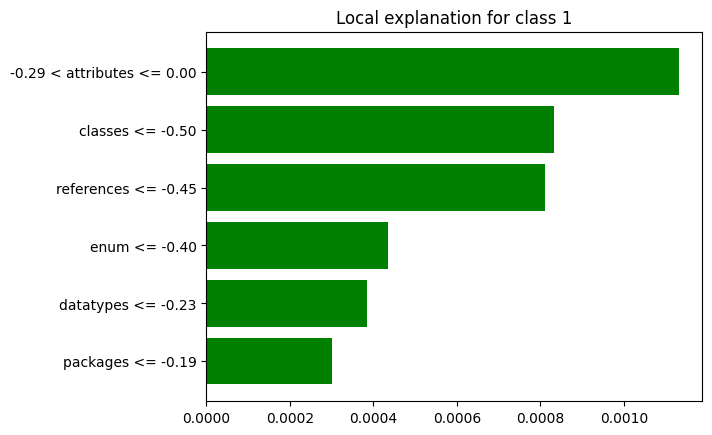

In [ ]:
breakdown_tp.plot()
shap_tp.plot()
lime_tp.plot()

In [ ]:
breakdown_df_tp, shap_df_tp, lime_df_tp, df_final_svc_tp = preprocess_dfs(breakdown_df_tp, shap_df_tp, lime_df_tp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tp)
print('----------------------------------------------')
print(shap_df_tp)
print('----------------------------------------------')
print(lime_df_tp)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1     classes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1     classes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_svc_tp

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       2  Positive       2  Positive
attributes         2  Positive       1  Positive       1  Positive
references         3  Positive       3  Positive       3  Positive
enum               4  Positive       4  Positive       4  Positive
packages           5  Positive       6  Positive       6  Positive
datatypes          6  Positive       5  Positive       5  Positive

### TN:

In [ ]:
breakdown_df_tn = breakdown_tn.result
shap_df_tn = shap_tn.result
lime_df_tn = lime_tn.result

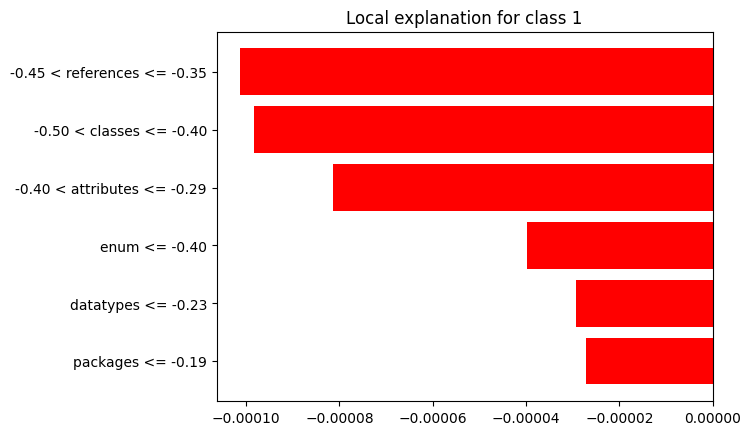

In [ ]:
breakdown_tn.plot()
shap_tn.plot()
lime_tn.plot()

In [ ]:
breakdown_df_tn, shap_df_tn, lime_df_tn, df_final_svc_tn = preprocess_dfs(breakdown_df_tn, shap_df_tn, lime_df_tn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tn)
print('----------------------------------------------')
print(shap_df_tn)
print('----------------------------------------------')
print(lime_df_tn)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2    packages        3  Positive
3     classes        4  Positive
4   datatypes        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Negative
2        enum        3  Negative
3     classes        4  Positive
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2  attributes        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative


In [ ]:
df_final_svc_tn

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       2  Negative       1  Negative
attributes         2  Negative       1  Negative       3  Negative
packages           3  Positive       6  Negative       6  Negative
classes            4  Positive       4  Positive       2  Negative
datatypes          5  Positive       5  Negative       5  Negative
enum               6  Positive       3  Negative       4  Negative

### FP:

In [ ]:
breakdown_df_fp = breakdown_fp.result
shap_df_fp = shap_fp.result
lime_df_fp = lime_fp.result

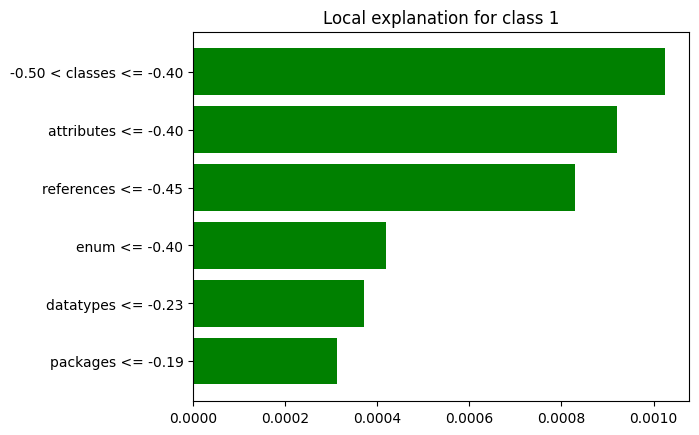

In [ ]:
breakdown_fp.plot()
shap_fp.plot()
lime_fp.plot()

In [ ]:
breakdown_df_fp, shap_df_fp, lime_df_fp, df_final_svc_fp = preprocess_dfs(breakdown_df_fp, shap_df_fp, lime_df_fp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fp)
print('----------------------------------------------')
print(shap_df_fp)
print('----------------------------------------------')
print(lime_df_fp)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3  references        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1  references        2  Positive
2     classes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_svc_fp

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Positive       4  Positive       4  Positive
classes            2  Positive       3  Positive       1  Positive
attributes         3  Positive       1  Positive       2  Positive
references         4  Positive       2  Positive       3  Positive
packages           5  Positive       6  Positive       6  Positive
datatypes          6  Positive       5  Positive       5  Positive

### FN:

In [ ]:
breakdown_df_fn = breakdown_fn.result
shap_df_fn = shap_fn.result
lime_df_fn = lime_fn.result

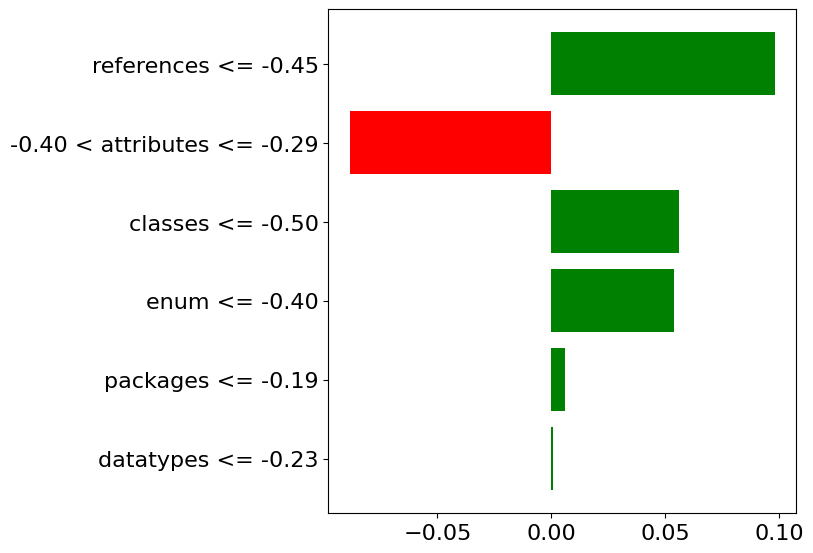

In [ ]:
plot = lime_fp.plot(return_figure=True)
plot.set_size_inches(9,6)
ax = plot.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_title('')
plot.subplots_adjust(left=0.38, top=0.95)
plot.savefig('rq3_lime.pdf')

In [ ]:
plot = breakdown_tn.plot(show=False)
plot.update_layout(width=800, height=400, font=dict(size=20))
plot.write_image("/content/ecore_dummy_svc_tn_bd.pdf")
plot.show()

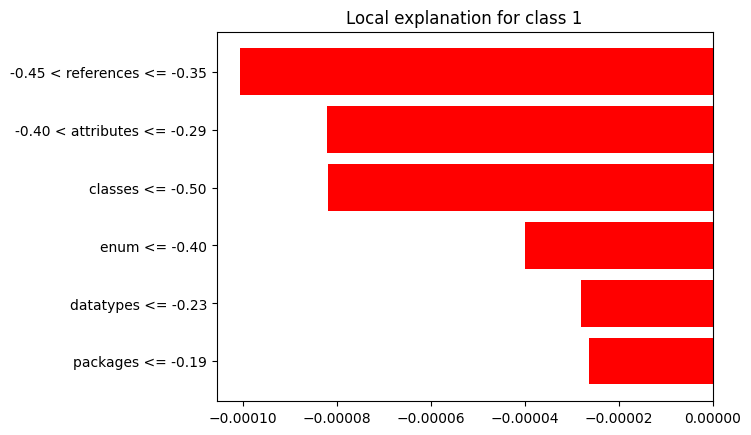

In [ ]:
breakdown_fn.plot()
shap_fn.plot()
lime_fn.plot()

In [ ]:
breakdown_df_fn, shap_df_fn, lime_df_fn, df_final_svc_fn = preprocess_dfs(breakdown_df_fn, shap_df_fn, lime_df_fn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fn)
print('----------------------------------------------')
print(shap_df_fn)
print('----------------------------------------------')
print(lime_df_fn)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2   datatypes        3  Positive
3        enum        4  Positive
4    packages        5  Negative
5     classes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative


In [ ]:
df_final_svc_fn

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       1  Negative       1  Negative
attributes         2  Negative       2  Negative       2  Negative
datatypes          3  Positive       5  Negative       5  Negative
enum               4  Positive       4  Negative       4  Negative
packages           5  Negative       6  Negative       6  Negative
classes            6  Negative       3  Negative       3  Negative

### Results SVC:

In [ ]:
df_topfeatures_tp_svc = top3_features(df_final_svc_tp, 'TP')
df_topfeatures_tn_svc = top3_features(df_final_svc_tn, 'TN')
df_topfeatures_fp_svc = top3_features(df_final_svc_fp, 'FP')
df_topfeatures_fn_svc = top3_features(df_final_svc_fn, 'FN')

df_topfeatures_svc = pd.concat([df_topfeatures_tp_svc, df_topfeatures_tn_svc, df_topfeatures_fp_svc, df_topfeatures_fn_svc])
df_topfeatures_svc

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"references, attributes, classes","references, attributes, classes","references, attributes, classes",1.000000,1.000000,1.000000
TN,"references, packages, attributes","references, attributes, enum","references, attributes, classes",0.666667,0.666667,0.666667
FP,"attributes, classes, enum","references, attributes, classes","references, attributes, classes",0.666667,0.666667,1.000000
FN,"references, datatypes, attributes","references, attributes, classes","references, attributes, classes",0.666667,0.666667,1.000000


In [ ]:
df_topfeatures_tp_rank_svc = top3_rank(df_final_svc_tp, 'TP')
df_topfeatures_tn_rank_svc = top3_rank(df_final_svc_tn, 'TN')
df_topfeatures_fp_rank_svc = top3_rank(df_final_svc_fp, 'FP')
df_topfeatures_fn_rank_svc = top3_rank(df_final_svc_fn, 'FN')

df_topfeatures_rank_svc = pd.concat([df_topfeatures_tp_rank_svc, df_topfeatures_tn_rank_svc, df_topfeatures_fp_rank_svc, df_topfeatures_fn_rank_svc])
df_topfeatures_rank_svc

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:classes, 2:attributes, 3:references","2:classes, 1:attributes, 3:references","2:classes, 1:attributes, 3:references",0.333333,0.333333,1.0
TN,"1:references, 2:attributes, 3:packages","2:references, 1:attributes, 3:enum","1:references, 3:attributes, 2:classes",0.000000,0.333333,0.0
FP,"1:enum, 2:classes, 3:attributes","3:classes, 1:attributes, 2:references","1:classes, 2:attributes, 3:references",0.000000,0.000000,0.0
FN,"1:references, 2:attributes, 3:datatypes","1:references, 2:attributes, 3:classes","1:references, 2:attributes, 3:classes",0.666667,0.666667,1.0


In [ ]:
df_topfeatures_tp_sign_svc = top3_sign(df_final_svc_tp, 'TP')
df_topfeatures_tn_sign_svc = top3_sign(df_final_svc_tn, 'TN')
df_topfeatures_fp_sign_svc = top3_sign(df_final_svc_fp, 'FP')
df_topfeatures_fn_sign_svc = top3_sign(df_final_svc_fn, 'FN')

df_topfeatures_sign_svc = pd.concat([df_topfeatures_tp_sign_svc, df_topfeatures_tn_sign_svc, df_topfeatures_fp_sign_svc, df_topfeatures_fn_sign_svc])
df_topfeatures_sign_svc

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"classes:Positive, attributes:Positive, referen...","classes:Positive, attributes:Positive, referen...","classes:Positive, attributes:Positive, referen...",1.000000,1.000000,1.000000
TN,"references:Negative, attributes:Negative, pack...","references:Negative, attributes:Negative, enum...","references:Negative, attributes:Negative, clas...",0.666667,0.666667,0.666667
FP,"enum:Positive, classes:Positive, attributes:Po...","classes:Positive, attributes:Positive, referen...","classes:Positive, attributes:Positive, referen...",0.666667,0.666667,1.000000
FN,"references:Negative, attributes:Negative, data...","references:Negative, attributes:Negative, clas...","references:Negative, attributes:Negative, clas...",0.666667,0.666667,1.000000


In [ ]:
df_topfeatures_tp_rank_sign_svc = top3_rank_sign(df_final_svc_tp, 'TP')
df_topfeatures_tn_rank_sign_svc = top3_rank_sign(df_final_svc_tn, 'TN')
df_topfeatures_fp_rank_sign_svc = top3_rank_sign(df_final_svc_fp, 'FP')
df_topfeatures_fn_rank_sign_svc = top3_rank_sign(df_final_svc_fn, 'FN')

df_topfeatures_rank_sign_svc = pd.concat([df_topfeatures_tp_rank_sign_svc, df_topfeatures_tn_rank_sign_svc, df_topfeatures_fp_rank_sign_svc, df_topfeatures_fn_rank_sign_svc])
df_topfeatures_rank_sign_svc

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:classes:Positive, 2:attributes:Positive, 3:r...","2:classes:Positive, 1:attributes:Positive, 3:r...","2:classes:Positive, 1:attributes:Positive, 3:r...",0.333333,0.333333,1.0
TN,"1:references:Negative, 2:attributes:Negative, ...","2:references:Negative, 1:attributes:Negative, ...","1:references:Negative, 3:attributes:Negative, ...",0.000000,0.333333,0.0
FP,"1:enum:Positive, 2:classes:Positive, 3:attribu...","3:classes:Positive, 1:attributes:Positive, 2:r...","1:classes:Positive, 2:attributes:Positive, 3:r...",0.000000,0.000000,0.0
FN,"1:references:Negative, 2:attributes:Negative, ...","1:references:Negative, 2:attributes:Negative, ...","1:references:Negative, 2:attributes:Negative, ...",0.666667,0.666667,1.0


## RF:

In [ ]:
exp = dx.Explainer(model_rf, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 3826 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3826 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7feb263cd6c0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.134, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.881, mean = -0.000642, max = 0.946
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
instance_tp = X_test.loc[inst_tp_rf]
instance_tn = X_test.loc[inst_tn_rf]
instance_fp = X_test.loc[inst_fp_rf]
instance_fn = X_test.loc[inst_fn_rf]

In [ ]:
breakdown_tp = exp.predict_parts(instance_tp, type="break_down",random_state=42)
shap_tp = exp.predict_parts(instance_tp, type="shap",random_state=42)
lime_tp = exp.predict_surrogate(instance_tp, random_state=42)

breakdown_tn = exp.predict_parts(instance_tn, type="break_down",random_state=42)
shap_tn = exp.predict_parts(instance_tn, type="shap",random_state=42)
lime_tn = exp.predict_surrogate(instance_tn, random_state=42)

breakdown_fp = exp.predict_parts(instance_fp, type="break_down",random_state=42)
shap_fp = exp.predict_parts(instance_fp, type="shap",random_state=42)
lime_fp = exp.predict_surrogate(instance_fp, random_state=42)

breakdown_fn = exp.predict_parts(instance_fn, type="break_down",random_state=42)
shap_fn = exp.predict_parts(instance_fn, type="shap",random_state=42)
lime_fn = exp.predict_surrogate(instance_fn, random_state=42)

### TP:

In [ ]:
breakdown_df_tp = breakdown_tp.result
shap_df_tp = shap_tp.result
lime_df_tp = lime_tp.result

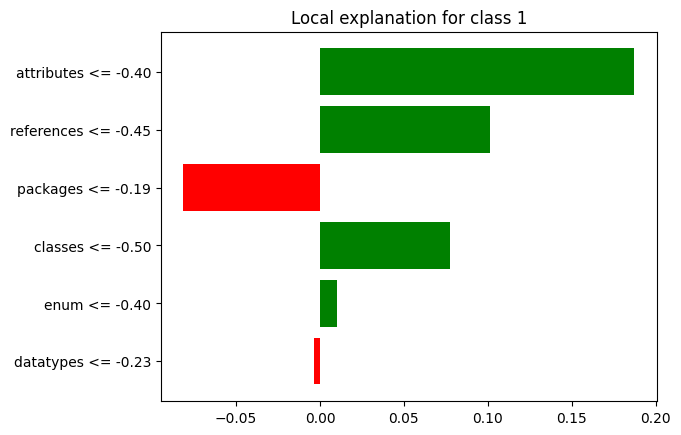

In [ ]:
breakdown_tp.plot()
shap_tp.plot()
lime_tp.plot()

In [ ]:
breakdown_df_tp, shap_df_tp, lime_df_tp, df_final_rf_tp = preprocess_dfs(breakdown_df_tp, shap_df_tp, lime_df_tp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tp)
print('----------------------------------------------')
print(shap_df_tp)
print('----------------------------------------------')
print(lime_df_tp)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1  references        2  Positive
2     classes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1  attributes        2  Positive
2     classes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1  references        2  Positive
2    packages        3  Negative
3     classes        4  Positive
4        enum        5  Positive
5   datatypes        6  Negative


In [ ]:
df_final_rf_tp

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Positive       2  Positive       1  Positive
references         2  Positive       1  Positive       2  Positive
classes            3  Positive       3  Positive       4  Positive
enum               4  Positive       4  Positive       5  Positive
datatypes          5  Positive       5  Positive       6  Negative
packages           6  Positive       6  Negative       3  Negative

### TN:

In [ ]:
breakdown_df_tn = breakdown_tn.result
shap_df_tn = shap_tn.result
lime_df_tn = lime_tn.result

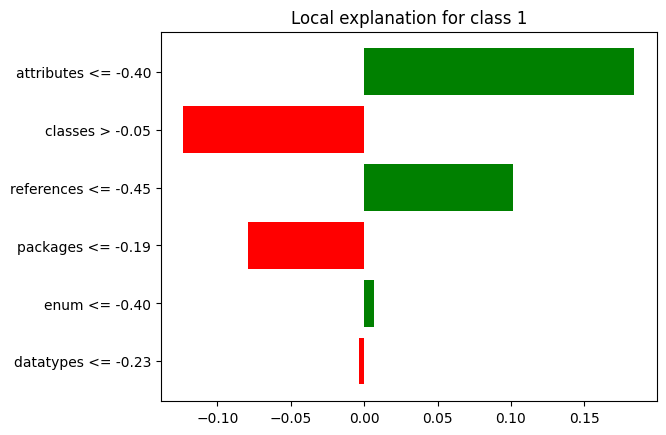

In [ ]:
breakdown_tn.plot()
shap_tn.plot()
lime_tn.plot()

In [ ]:
breakdown_df_tn, shap_df_tn, lime_df_tn, df_final_rf_tn = preprocess_dfs(breakdown_df_tn, shap_df_tn, lime_df_tn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tn)
print('----------------------------------------------')
print(shap_df_tn)
print('----------------------------------------------')
print(lime_df_tn)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Negative
3        enum        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2        enum        3  Negative
3  attributes        4  Positive
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1     classes        2  Negative
2  references        3  Positive
3    packages        4  Negative
4        enum        5  Positive
5   datatypes        6  Negative


In [ ]:
df_final_rf_tn

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       2  Negative
references         2  Positive       2  Positive       3  Positive
attributes         3  Negative       4  Positive       1  Positive
enum               4  Negative       3  Negative       5  Positive
packages           5  Negative       5  Negative       4  Negative
datatypes          6  Negative       6  Negative       6  Negative

### FP:

In [ ]:
breakdown_df_fp = breakdown_fp.result
shap_df_fp = shap_fp.result
lime_df_fp = lime_fp.result

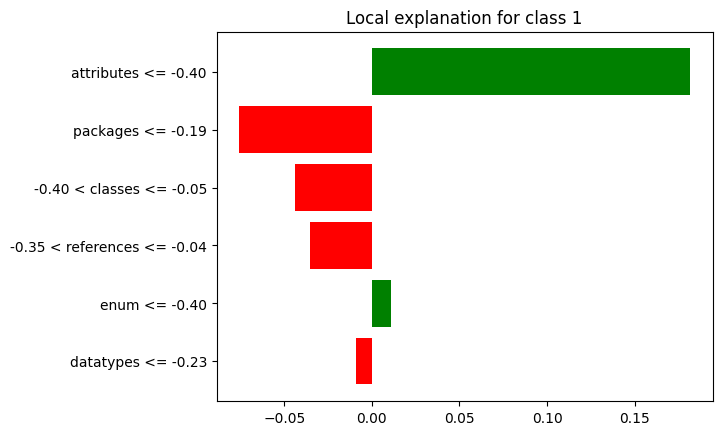

In [ ]:
breakdown_fp.plot()
shap_fp.plot()
lime_fp.plot()

In [ ]:
breakdown_df_fp, shap_df_fp, lime_df_fp, df_final_rf_fp = preprocess_dfs(breakdown_df_fp, shap_df_fp, lime_df_fp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fp)
print('----------------------------------------------')
print(shap_df_fp)
print('----------------------------------------------')
print(lime_df_fp)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1     classes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1    packages        2  Negative
2     classes        3  Negative
3  references        4  Negative
4        enum        5  Positive
5   datatypes        6  Negative


In [ ]:
df_final_rf_fp

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       3  Positive       4  Negative
classes            2  Positive       2  Positive       3  Negative
attributes         3  Positive       1  Positive       1  Positive
enum               4  Positive       4  Positive       5  Positive
packages           5  Positive       6  Positive       2  Negative
datatypes          6  Positive       5  Positive       6  Negative

### FN:

In [ ]:
breakdown_df_fn = breakdown_fn.result
shap_df_fn = shap_fn.result
lime_df_fn = lime_fn.result

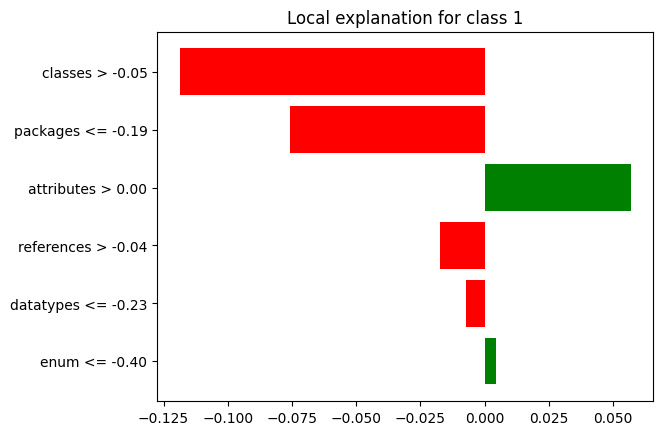

In [ ]:
breakdown_fn.plot()
shap_fn.plot()
lime_fn.plot()

In [ ]:
breakdown_df_fn, shap_df_fn, lime_df_fn, df_final_rf_fn = preprocess_dfs(breakdown_df_fn, shap_df_fn, lime_df_fn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fn)
print('----------------------------------------------')
print(shap_df_fn)
print('----------------------------------------------')
print(lime_df_fn)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Positive
2  references        3  Negative
3    packages        4  Negative
4   datatypes        5  Positive
5        enum        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3        enum        4  Positive
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1    packages        2  Negative
2  attributes        3  Positive
3  references        4  Negative
4   datatypes        5  Negative
5        enum        6  Positive


In [ ]:
df_final_rf_fn

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
attributes         2  Positive       3  Negative       3  Positive
references         3  Negative       2  Negative       4  Negative
packages           4  Negative       6  Negative       2  Negative
datatypes          5  Positive       5  Negative       5  Negative
enum               6  Negative       4  Positive       6  Positive

### Results RF:

In [ ]:
df_topfeatures_tp_rf = top3_features(df_final_rf_tp, 'TP')
df_topfeatures_tn_rf = top3_features(df_final_rf_tn, 'TN')
df_topfeatures_fp_rf = top3_features(df_final_rf_fp, 'FP')
df_topfeatures_fn_rf = top3_features(df_final_rf_fn, 'FN')

df_topfeatures_rf = pd.concat([df_topfeatures_tp_rf, df_topfeatures_tn_rf, df_topfeatures_fp_rf, df_topfeatures_fn_rf])
df_topfeatures_rf

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"references, attributes, classes","references, attributes, classes","references, packages, attributes",1.000000,0.666667,0.666667
TN,"references, attributes, classes","references, classes, enum","references, attributes, classes",0.666667,1.000000,0.666667
FP,"references, attributes, classes","references, attributes, classes","packages, attributes, classes",1.000000,0.666667,0.666667
FN,"references, attributes, classes","references, attributes, classes","packages, attributes, classes",1.000000,0.666667,0.666667


In [ ]:
df_topfeatures_tp_rank_rf = top3_rank(df_final_rf_tp, 'TP')
df_topfeatures_tn_rank_rf = top3_rank(df_final_rf_tn, 'TN')
df_topfeatures_fp_rank_rf = top3_rank(df_final_rf_fp, 'FP')
df_topfeatures_fn_rank_rf = top3_rank(df_final_rf_fn, 'FN')

df_topfeatures_rank_rf = pd.concat([df_topfeatures_tp_rank_rf, df_topfeatures_tn_rank_rf, df_topfeatures_fp_rank_rf, df_topfeatures_fn_rank_rf])
df_topfeatures_rank_rf

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:attributes, 2:references, 3:classes","2:attributes, 1:references, 3:classes","1:attributes, 2:references, 3:packages",0.333333,0.666667,0.000000
TN,"1:classes, 2:references, 3:attributes","1:classes, 2:references, 3:enum","2:classes, 3:references, 1:attributes",0.666667,0.000000,0.000000
FP,"1:references, 2:classes, 3:attributes","3:references, 2:classes, 1:attributes","3:classes, 1:attributes, 2:packages",0.333333,0.000000,0.333333
FN,"1:classes, 2:attributes, 3:references","1:classes, 3:attributes, 2:references","1:classes, 3:attributes, 2:packages",0.333333,0.333333,0.666667


In [ ]:
df_topfeatures_tp_sign_rf = top3_sign(df_final_rf_tp, 'TP')
df_topfeatures_tn_sign_rf = top3_sign(df_final_rf_tn, 'TN')
df_topfeatures_fp_sign_rf = top3_sign(df_final_rf_fp, 'FP')
df_topfeatures_fn_sign_rf = top3_sign(df_final_rf_fn, 'FN')

df_topfeatures_sign_rf = pd.concat([df_topfeatures_tp_sign_rf, df_topfeatures_tn_sign_rf, df_topfeatures_fp_sign_rf, df_topfeatures_fn_sign_rf])
df_topfeatures_sign_rf

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"attributes:Positive, references:Positive, clas...","attributes:Positive, references:Positive, clas...","attributes:Positive, references:Positive, pack...",1.000000,0.666667,0.666667
TN,"classes:Negative, references:Positive, attribu...","classes:Negative, references:Positive, enum:Ne...","classes:Negative, references:Positive, attribu...",0.666667,0.666667,0.666667
FP,"references:Positive, classes:Positive, attribu...","references:Positive, classes:Positive, attribu...","classes:Negative, attributes:Positive, package...",1.000000,0.333333,0.333333
FN,"classes:Negative, attributes:Positive, referen...","classes:Negative, attributes:Negative, referen...","classes:Negative, attributes:Positive, package...",0.666667,0.666667,0.333333


In [ ]:
df_topfeatures_tp_rank_sign_rf = top3_rank_sign(df_final_rf_tp, 'TP')
df_topfeatures_tn_rank_sign_rf = top3_rank_sign(df_final_rf_tn, 'TN')
df_topfeatures_fp_rank_sign_rf = top3_rank_sign(df_final_rf_fp, 'FP')
df_topfeatures_fn_rank_sign_rf = top3_rank_sign(df_final_rf_fn, 'FN')

df_topfeatures_rank_sign_rf = pd.concat([df_topfeatures_tp_rank_sign_rf, df_topfeatures_tn_rank_sign_rf, df_topfeatures_fp_rank_sign_rf, df_topfeatures_fn_rank_sign_rf])
df_topfeatures_rank_sign_rf

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:attributes:Positive, 2:references:Positive, ...","2:attributes:Positive, 1:references:Positive, ...","1:attributes:Positive, 2:references:Positive, ...",0.333333,0.666667,0.000000
TN,"1:classes:Negative, 2:references:Positive, 3:a...","1:classes:Negative, 2:references:Positive, 3:e...","2:classes:Negative, 3:references:Positive, 1:a...",0.666667,0.000000,0.000000
FP,"1:references:Positive, 2:classes:Positive, 3:a...","3:references:Positive, 2:classes:Positive, 1:a...","3:classes:Negative, 1:attributes:Positive, 2:p...",0.333333,0.000000,0.333333
FN,"1:classes:Negative, 2:attributes:Positive, 3:r...","1:classes:Negative, 3:attributes:Negative, 2:r...","1:classes:Negative, 3:attributes:Positive, 2:p...",0.333333,0.333333,0.333333


## KNN:

In [ ]:
exp = dx.Explainer(model_knn, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 3826 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3826 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7e3daf51b760> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.133, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.000157, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
instance_tp = X_test.loc[inst_tp_knn]
instance_tn = X_test.loc[inst_tn_knn]
instance_fp = X_test.loc[inst_fp_knn]
instance_fn = X_test.loc[inst_fn_knn]

In [ ]:
breakdown_tp = exp.predict_parts(instance_tp, type="break_down",random_state=42)
shap_tp = exp.predict_parts(instance_tp, type="shap",random_state=42)
lime_tp = exp.predict_surrogate(instance_tp, random_state=42)

breakdown_tn = exp.predict_parts(instance_tn, type="break_down",random_state=42)
shap_tn = exp.predict_parts(instance_tn, type="shap",random_state=42)
lime_tn = exp.predict_surrogate(instance_tn, random_state=42)

breakdown_fp = exp.predict_parts(instance_fp, type="break_down",random_state=42)
shap_fp = exp.predict_parts(instance_fp, type="shap",random_state=42)
lime_fp = exp.predict_surrogate(instance_fp, random_state=42)

breakdown_fn = exp.predict_parts(instance_fn, type="break_down",random_state=42)
shap_fn = exp.predict_parts(instance_fn, type="shap",random_state=42)
lime_fn = exp.predict_surrogate(instance_fn, random_state=42)

### TP:

In [ ]:
breakdown_df_tp = breakdown_tp.result
shap_df_tp = shap_tp.result
lime_df_tp = lime_tp.result

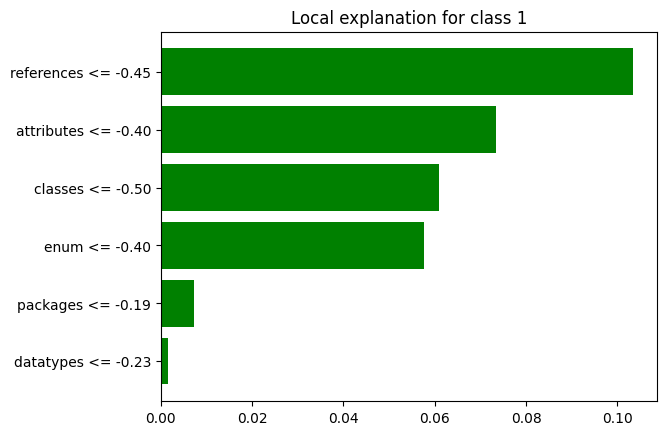

In [ ]:
breakdown_tp.plot()
shap_tp.plot()
lime_tp.plot()

In [ ]:
breakdown_df_tp, shap_df_tp, lime_df_tp, df_final_knn_tp = preprocess_dfs(breakdown_df_tp, shap_df_tp, lime_df_tp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tp)
print('----------------------------------------------')
print(shap_df_tp)
print('----------------------------------------------')
print(lime_df_tp)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1        enum        2  Positive
2  references        3  Positive
3   datatypes        4  Positive
4  attributes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1  attributes        2  Positive
2     classes        3  Positive
3        enum        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive


In [ ]:
df_final_knn_tp

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       2  Positive       3  Positive
enum               2  Positive       4  Positive       4  Positive
references         3  Positive       1  Positive       1  Positive
datatypes          4  Positive       5  Positive       6  Positive
attributes         5  Positive       3  Positive       2  Positive
packages           6  Positive       6  Negative       5  Positive

### TN:

In [ ]:
breakdown_df_tn = breakdown_tn.result
shap_df_tn = shap_tn.result
lime_df_tn = lime_tn.result

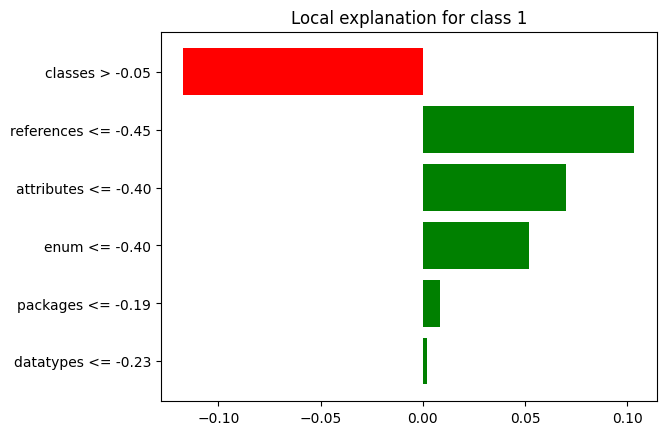

In [ ]:
breakdown_tn.plot()
shap_tn.plot()
lime_tn.plot()

In [ ]:
breakdown_df_tn, shap_df_tn, lime_df_tn, df_final_knn_tn = preprocess_dfs(breakdown_df_tn, shap_df_tn, lime_df_tn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tn)
print('----------------------------------------------')
print(shap_df_tn)
print('----------------------------------------------')
print(lime_df_tn)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2        enum        3  Negative
3  attributes        4  Positive
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Positive
3    packages        4  Negative
4   datatypes        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive


In [ ]:
df_final_knn_tn

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
references         2  Positive       2  Positive       2  Positive
enum               3  Negative       6  Positive       4  Positive
attributes         4  Positive       3  Positive       3  Positive
packages           5  Negative       4  Negative       5  Positive
datatypes          6  Positive       5  Positive       6  Positive

### FP:

In [ ]:
breakdown_df_fp = breakdown_fp.result
shap_df_fp = shap_fp.result
lime_df_fp = lime_fp.result

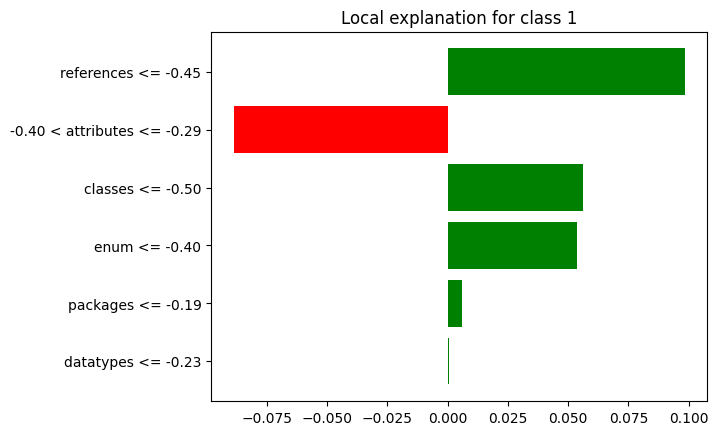

In [ ]:
breakdown_fp.plot()
shap_fp.plot()
lime_fp.plot()

In [ ]:
breakdown_df_fp, shap_df_fp, lime_df_fp, df_final_knn_fp = preprocess_dfs(breakdown_df_fp, shap_df_fp, lime_df_fp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fp)
print('----------------------------------------------')
print(shap_df_fp)
print('----------------------------------------------')
print(lime_df_fp)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1     classes        2  Positive
2        enum        3  Positive
3   datatypes        4  Positive
4  references        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1  attributes        2  Negative
2     classes        3  Positive
3        enum        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive


In [ ]:
df_final_knn_fp

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Positive       3  Positive       2  Negative
classes            2  Positive       2  Positive       3  Positive
enum               3  Positive       4  Positive       4  Positive
datatypes          4  Positive       5  Positive       6  Positive
references         5  Positive       1  Positive       1  Positive
packages           6  Negative       6  Positive       5  Positive

### FN:

In [ ]:
breakdown_df_fn = breakdown_fn.result
shap_df_fn = shap_fn.result
lime_df_fn = lime_fn.result

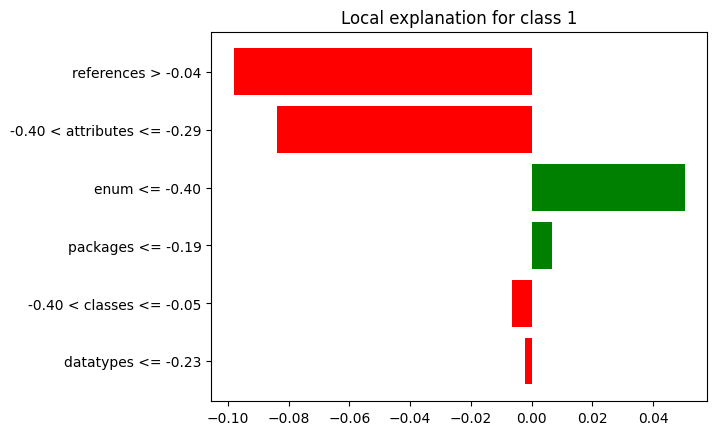

In [ ]:
breakdown_fn.plot()
shap_fn.plot()
lime_fn.plot()

In [ ]:
breakdown_df_fn, shap_df_fn, lime_df_fn, df_final_knn_fn = preprocess_dfs(breakdown_df_fn, shap_df_fn, lime_df_fn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fn)
print('----------------------------------------------')
print(shap_df_fn)
print('----------------------------------------------')
print(lime_df_fn)

['enum', 'attributes', 'references', 'classes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Positive
2  references        3  Negative
3    packages        4  Negative
4        enum        5  Positive
5  attributes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2    packages        3  Negative
3  references        4  Negative
4   datatypes        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2        enum        3  Positive
3    packages        4  Positive
4     classes        5  Negative
5   datatypes        6  Negative


In [ ]:
df_final_knn_fn

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       5  Negative
datatypes          2  Positive       5  Positive       6  Negative
references         3  Negative       4  Negative       1  Negative
packages           4  Negative       3  Negative       4  Positive
enum               5  Positive       6  Positive       3  Positive
attributes         6  Positive       2  Negative       2  Negative

### Results KNN:

In [ ]:
df_topfeatures_tp_knn = top3_features(df_final_knn_tp, 'TP')
df_topfeatures_tn_knn = top3_features(df_final_knn_tn, 'TN')
df_topfeatures_fp_knn = top3_features(df_final_knn_fp, 'FP')
df_topfeatures_fn_knn = top3_features(df_final_knn_fn, 'FN')

df_topfeatures_knn = pd.concat([df_topfeatures_tp_knn, df_topfeatures_tn_knn, df_topfeatures_fp_knn, df_topfeatures_fn_knn])
df_topfeatures_knn

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"references, classes, enum","references, attributes, classes","references, attributes, classes",0.666667,0.666667,1.000000
TN,"references, classes, enum","references, attributes, classes","references, attributes, classes",0.666667,0.666667,1.000000
FP,"attributes, classes, enum","references, attributes, classes","references, attributes, classes",0.666667,0.666667,1.000000
FN,"references, datatypes, classes","packages, attributes, classes","references, attributes, enum",0.333333,0.333333,0.333333


In [ ]:
df_topfeatures_tp_rank_knn = top3_rank(df_final_knn_tp, 'TP')
df_topfeatures_tn_rank_knn = top3_rank(df_final_knn_tn, 'TN')
df_topfeatures_fp_rank_knn = top3_rank(df_final_knn_fp, 'FP')
df_topfeatures_fn_rank_knn = top3_rank(df_final_knn_fn, 'FN')

df_topfeatures_rank_knn = pd.concat([df_topfeatures_tp_rank_knn, df_topfeatures_tn_rank_knn, df_topfeatures_fp_rank_knn, df_topfeatures_fn_rank_knn])
df_topfeatures_rank_knn

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:classes, 2:enum, 3:references","2:classes, 1:references, 3:attributes","3:classes, 1:references, 2:attributes",0.000000,0.000000,0.333333
TN,"1:classes, 2:references, 3:enum","1:classes, 2:references, 3:attributes","1:classes, 2:references, 3:attributes",0.666667,0.666667,1.000000
FP,"1:attributes, 2:classes, 3:enum","3:attributes, 2:classes, 1:references","2:attributes, 3:classes, 1:references",0.333333,0.000000,0.333333
FN,"1:classes, 2:datatypes, 3:references","1:classes, 3:packages, 2:attributes","1:references, 3:enum, 2:attributes",0.333333,0.000000,0.333333


In [ ]:
df_topfeatures_tp_sign_knn = top3_sign(df_final_knn_tp, 'TP')
df_topfeatures_tn_sign_knn = top3_sign(df_final_knn_tn, 'TN')
df_topfeatures_fp_sign_knn = top3_sign(df_final_knn_fp, 'FP')
df_topfeatures_fn_sign_knn = top3_sign(df_final_knn_fn, 'FN')

df_topfeatures_sign_knn = pd.concat([df_topfeatures_tp_sign_knn, df_topfeatures_tn_sign_knn, df_topfeatures_fp_sign_knn, df_topfeatures_fn_sign_knn])
df_topfeatures_sign_knn

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"classes:Positive, enum:Positive, references:Po...","classes:Positive, references:Positive, attribu...","classes:Positive, references:Positive, attribu...",0.666667,0.666667,1.000000
TN,"classes:Negative, references:Positive, enum:Ne...","classes:Negative, references:Positive, attribu...","classes:Negative, references:Positive, attribu...",0.666667,0.666667,1.000000
FP,"attributes:Positive, classes:Positive, enum:Po...","attributes:Positive, classes:Positive, referen...","attributes:Negative, classes:Positive, referen...",0.666667,0.333333,0.666667
FN,"classes:Negative, datatypes:Positive, referenc...","classes:Negative, packages:Negative, attribute...","references:Negative, enum:Positive, attributes...",0.333333,0.333333,0.333333


In [ ]:
df_topfeatures_tp_rank_sign_knn = top3_rank_sign(df_final_knn_tp, 'TP')
df_topfeatures_tn_rank_sign_knn = top3_rank_sign(df_final_knn_tn, 'TN')
df_topfeatures_fp_rank_sign_knn = top3_rank_sign(df_final_knn_fp, 'FP')
df_topfeatures_fn_rank_sign_knn = top3_rank_sign(df_final_knn_fn, 'FN')

df_topfeatures_rank_sign_knn = pd.concat([df_topfeatures_tp_rank_sign_knn, df_topfeatures_tn_rank_sign_knn, df_topfeatures_fp_rank_sign_knn, df_topfeatures_fn_rank_sign_knn])
df_topfeatures_rank_sign_knn

,TOP3 Breakdown,TOP3 Shap,TOP3 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:classes:Positive, 2:enum:Positive, 3:referen...","2:classes:Positive, 1:references:Positive, 3:a...","3:classes:Positive, 1:references:Positive, 2:a...",0.000000,0.000000,0.333333
TN,"1:classes:Negative, 2:references:Positive, 3:e...","1:classes:Negative, 2:references:Positive, 3:a...","1:classes:Negative, 2:references:Positive, 3:a...",0.666667,0.666667,1.000000
FP,"1:attributes:Positive, 2:classes:Positive, 3:e...","3:attributes:Positive, 2:classes:Positive, 1:r...","2:attributes:Negative, 3:classes:Positive, 1:r...",0.333333,0.000000,0.333333
FN,"1:classes:Negative, 2:datatypes:Positive, 3:re...","1:classes:Negative, 3:packages:Negative, 2:att...","1:references:Negative, 3:enum:Positive, 2:attr...",0.333333,0.000000,0.333333
